##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Video classification with a 3D convolutional neural network

This tutorial demonstrates training a 3D convolutional neural network (CNN) for video classification using the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) action recognition dataset. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  In this tutorial, you will:

* Build an input pipeline
* Build a 3D convolutional neural network model with residual connections using Keras functional API
* Train the model
* Evaluate and test the model

This video classification tutorial is the second part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [8]:
#!pip install remotezip tqdm opencv-python einops 
!pip install remotezip tqdm einops opencv-python-headless seaborn #for wsl miniconda environment
!pip install -U tensorflow keras

In [9]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

2025-05-03 14:03:08.739687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746295389.120475   26874 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746295389.157362   26874 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746295389.446360   26874 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746295389.446723   26874 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746295389.446726   26874 computation_placer.cc:177] computation placer alr

## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [10]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [11]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|████████████████████████████████████████████████| 300/300 [02:21<00:00,  2.12it/s]


val :


100%|████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


test :


100%|████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]


  7%|▋         | 22/300 [00:01<00:16, 16.58it/s]

  8%|▊         | 25/300 [00:01<00:16, 16.90it/s]

  9%|▉         | 28/300 [00:01<00:15, 18.04it/s]

 10%|█         | 30/300 [00:01<00:14, 18.13it/s]

 11%|█         | 32/300 [00:02<00:18, 14.34it/s]

 12%|█▏        | 35/300 [00:02<00:16, 16.06it/s]

 12%|█▏        | 37/300 [00:02<00:16, 16.34it/s]

 13%|█▎        | 40/300 [00:02<00:14, 17.65it/s]

 14%|█▍        | 42/300 [00:02<00:16, 15.96it/s]

 15%|█▍        | 44/300 [00:02<00:15, 16.78it/s]

 16%|█▌        | 47/300 [00:02<00:13, 18.19it/s]

 17%|█▋        | 50/300 [00:03<00:13, 18.75it/s]

 18%|█▊        | 53/300 [00:03<00:13, 18.97it/s]

 18%|█▊        | 55/300 [00:03<00:12, 18.88it/s]

 19%|█▉        | 58/300 [00:03<00:12, 20.14it/s]

 20%|██        | 61/300 [00:03<00:13, 17.99it/s]

 21%|██        | 63/300 [00:03<00:15, 14.86it/s]

 22%|██▏       | 65/300 [00:04<00:16, 14.08it/s]

 22%|██▏       | 67/300 [00:04<00:16, 13.73it/s]

 23%|██▎       | 69/300 [00:04<00:15, 14.50it/s]

 24%|██▎       | 71/300 [00:04<00:16, 13.68it/s]

 25%|██▍       | 74/300 [00:04<00:14, 16.06it/s]

 25%|██▌       | 76/300 [00:04<00:15, 14.27it/s]

 26%|██▌       | 78/300 [00:04<00:15, 14.02it/s]

 27%|██▋       | 80/300 [00:05<00:14, 15.07it/s]

 27%|██▋       | 82/300 [00:05<00:14, 14.55it/s]

 28%|██▊       | 85/300 [00:05<00:12, 17.06it/s]

 29%|██▉       | 87/300 [00:05<00:12, 17.58it/s]

 30%|██▉       | 89/300 [00:05<00:12, 17.36it/s]

 30%|███       | 91/300 [00:05<00:12, 16.54it/s]

 31%|███       | 93/300 [00:05<00:13, 15.44it/s]

 32%|███▏      | 95/300 [00:06<00:14, 14.61it/s]

 32%|███▏      | 97/300 [00:06<00:16, 12.65it/s]

 33%|███▎      | 99/300 [00:06<00:15, 12.79it/s]

 34%|███▍      | 102/300 [00:06<00:13, 14.93it/s]

 35%|███▍      | 104/300 [00:06<00:12, 15.98it/s]

 36%|███▌      | 107/300 [00:06<00:10, 17.63it/s]

 37%|███▋      | 110/300 [00:06<00:11, 16.46it/s]

 37%|███▋      | 112/300 [00:07<00:11, 16.96it/s]

 38%|███▊      | 114/300 [00:07<00:10, 17.29it/s]

 39%|███▊      | 116/300 [00:07<00:10, 17.29it/s]

 40%|███▉      | 119/300 [00:07<00:09, 18.95it/s]

 40%|████      | 121/300 [00:07<00:10, 17.37it/s]

 41%|████▏     | 124/300 [00:07<00:10, 16.29it/s]

 42%|████▏     | 126/300 [00:07<00:12, 13.64it/s]

 43%|████▎     | 128/300 [00:08<00:11, 14.58it/s]

 44%|████▎     | 131/300 [00:08<00:10, 16.00it/s]

 45%|████▍     | 134/300 [00:08<00:09, 17.63it/s]

 45%|████▌     | 136/300 [00:08<00:09, 17.81it/s]

 46%|████▌     | 138/300 [00:08<00:10, 15.71it/s]

 47%|████▋     | 140/300 [00:08<00:09, 16.59it/s]

 48%|████▊     | 143/300 [00:08<00:08, 17.82it/s]

 48%|████▊     | 145/300 [00:09<00:08, 18.27it/s]

 49%|████▉     | 148/300 [00:09<00:07, 19.13it/s]

 50%|█████     | 151/300 [00:09<00:08, 17.16it/s]

 51%|█████     | 153/300 [00:09<00:10, 13.54it/s]

 52%|█████▏    | 155/300 [00:09<00:12, 11.58it/s]

 52%|█████▏    | 157/300 [00:10<00:13, 10.25it/s]

 53%|█████▎    | 159/300 [00:10<00:13, 10.75it/s]

 54%|█████▎    | 161/300 [00:10<00:12, 11.01it/s]

 54%|█████▍    | 163/300 [00:10<00:13, 10.21it/s]

 55%|█████▌    | 165/300 [00:10<00:12, 11.02it/s]

 56%|█████▌    | 167/300 [00:11<00:13,  9.90it/s]

 56%|█████▋    | 169/300 [00:11<00:12, 10.29it/s]

 57%|█████▋    | 171/300 [00:11<00:12, 10.39it/s]

 58%|█████▊    | 173/300 [00:11<00:10, 12.04it/s]

 58%|█████▊    | 175/300 [00:11<00:10, 12.45it/s]

 59%|█████▉    | 177/300 [00:11<00:09, 12.33it/s]

 60%|█████▉    | 179/300 [00:11<00:09, 13.43it/s]

 60%|██████    | 181/300 [00:12<00:09, 12.78it/s]

 61%|██████    | 183/300 [00:12<00:10, 11.60it/s]

 62%|██████▏   | 185/300 [00:12<00:08, 13.16it/s]

 62%|██████▏   | 187/300 [00:12<00:08, 12.68it/s]

 63%|██████▎   | 190/300 [00:12<00:07, 14.90it/s]

 64%|██████▍   | 193/300 [00:12<00:06, 16.69it/s]

 65%|██████▌   | 196/300 [00:13<00:05, 17.79it/s]

 66%|██████▋   | 199/300 [00:13<00:05, 18.77it/s]

 67%|██████▋   | 202/300 [00:13<00:04, 19.74it/s]

 68%|██████▊   | 205/300 [00:13<00:04, 19.78it/s]

 69%|██████▉   | 208/300 [00:13<00:04, 20.44it/s]

 70%|███████   | 211/300 [00:13<00:04, 19.19it/s]

 71%|███████   | 213/300 [00:13<00:05, 16.71it/s]

 72%|███████▏  | 215/300 [00:14<00:05, 15.92it/s]

 73%|███████▎  | 218/300 [00:14<00:05, 15.19it/s]

 73%|███████▎  | 220/300 [00:14<00:05, 15.28it/s]

 74%|███████▍  | 223/300 [00:14<00:04, 16.82it/s]

 75%|███████▌  | 225/300 [00:14<00:04, 17.19it/s]

 76%|███████▌  | 228/300 [00:14<00:04, 17.40it/s]

 77%|███████▋  | 231/300 [00:15<00:03, 18.68it/s]

 78%|███████▊  | 234/300 [00:15<00:03, 19.32it/s]

 79%|███████▊  | 236/300 [00:15<00:03, 19.28it/s]

 80%|███████▉  | 239/300 [00:15<00:03, 19.30it/s]

 80%|████████  | 241/300 [00:15<00:03, 16.61it/s]

 81%|████████  | 243/300 [00:15<00:03, 16.62it/s]

 82%|████████▏ | 245/300 [00:15<00:03, 16.23it/s]

 82%|████████▏ | 247/300 [00:15<00:03, 16.82it/s]

 83%|████████▎ | 250/300 [00:16<00:02, 18.25it/s]

 84%|████████▍ | 253/300 [00:16<00:02, 19.59it/s]

 85%|████████▌ | 256/300 [00:16<00:02, 19.86it/s]

 86%|████████▌ | 258/300 [00:16<00:02, 19.60it/s]

 87%|████████▋ | 260/300 [00:16<00:02, 18.95it/s]

 88%|████████▊ | 263/300 [00:16<00:01, 19.02it/s]

 88%|████████▊ | 265/300 [00:16<00:01, 18.67it/s]

 89%|████████▉ | 268/300 [00:17<00:01, 19.60it/s]

 90%|█████████ | 271/300 [00:17<00:01, 18.52it/s]

 91%|█████████ | 273/300 [00:17<00:01, 15.29it/s]

 92%|█████████▏| 275/300 [00:17<00:01, 13.46it/s]

 92%|█████████▏| 277/300 [00:17<00:01, 13.25it/s]

 93%|█████████▎| 279/300 [00:17<00:01, 14.44it/s]

 94%|█████████▍| 282/300 [00:18<00:01, 16.58it/s]

 95%|█████████▌| 285/300 [00:18<00:00, 17.67it/s]

 96%|█████████▌| 288/300 [00:18<00:00, 18.77it/s]

 97%|█████████▋| 290/300 [00:18<00:00, 18.71it/s]

 98%|█████████▊| 293/300 [00:18<00:00, 19.80it/s]

 98%|█████████▊| 295/300 [00:18<00:00, 17.41it/s]

 99%|█████████▉| 298/300 [00:18<00:00, 18.52it/s]

100%|██████████| 300/300 [00:18<00:00, 18.02it/s]

100%|██████████| 300/300 [00:18<00:00, 15.82it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:11,  8.62it/s]

  2%|▏         | 2/100 [00:00<00:11,  8.26it/s]

  4%|▍         | 4/100 [00:00<00:08, 11.62it/s]

  7%|▋         | 7/100 [00:00<00:05, 15.53it/s]

 10%|█         | 10/100 [00:00<00:05, 16.30it/s]

 12%|█▏        | 12/100 [00:00<00:06, 14.43it/s]

 14%|█▍        | 14/100 [00:01<00:06, 14.10it/s]

 17%|█▋        | 17/100 [00:01<00:05, 16.28it/s]

 20%|██        | 20/100 [00:01<00:04, 16.61it/s]

 22%|██▏       | 22/100 [00:01<00:05, 15.10it/s]

 24%|██▍       | 24/100 [00:01<00:05, 13.66it/s]

 26%|██▌       | 26/100 [00:01<00:05, 13.52it/s]

 28%|██▊       | 28/100 [00:02<00:05, 12.47it/s]

 30%|███       | 30/100 [00:02<00:05, 13.01it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.53it/s]

 34%|███▍      | 34/100 [00:02<00:05, 11.06it/s]

 36%|███▌      | 36/100 [00:02<00:05, 11.71it/s]

 38%|███▊      | 38/100 [00:02<00:05, 11.99it/s]

 41%|████      | 41/100 [00:03<00:04, 12.67it/s]

 43%|████▎     | 43/100 [00:03<00:04, 12.28it/s]

 45%|████▌     | 45/100 [00:03<00:04, 13.22it/s]

 48%|████▊     | 48/100 [00:03<00:03, 15.41it/s]

 50%|█████     | 50/100 [00:03<00:03, 16.01it/s]

 52%|█████▏    | 52/100 [00:03<00:03, 12.50it/s]

 54%|█████▍    | 54/100 [00:04<00:04, 11.30it/s]

 56%|█████▌    | 56/100 [00:04<00:04, 10.66it/s]

 58%|█████▊    | 58/100 [00:04<00:03, 11.26it/s]

 60%|██████    | 60/100 [00:04<00:03, 11.59it/s]

 62%|██████▏   | 62/100 [00:04<00:02, 13.07it/s]

 65%|██████▌   | 65/100 [00:04<00:02, 15.55it/s]

 68%|██████▊   | 68/100 [00:05<00:01, 17.17it/s]

 71%|███████   | 71/100 [00:05<00:01, 18.45it/s]

 74%|███████▍  | 74/100 [00:05<00:01, 19.71it/s]

 77%|███████▋  | 77/100 [00:05<00:01, 19.87it/s]

 80%|████████  | 80/100 [00:05<00:01, 19.93it/s]

 83%|████████▎ | 83/100 [00:05<00:00, 20.51it/s]

 86%|████████▌ | 86/100 [00:05<00:00, 20.02it/s]

 89%|████████▉ | 89/100 [00:06<00:00, 20.21it/s]

 92%|█████████▏| 92/100 [00:06<00:00, 20.24it/s]

 95%|█████████▌| 95/100 [00:06<00:00, 21.08it/s]

 98%|█████████▊| 98/100 [00:06<00:00, 21.22it/s]

100%|██████████| 100/100 [00:06<00:00, 15.23it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:05, 17.73it/s]

  5%|▌         | 5/100 [00:00<00:04, 20.38it/s]

  8%|▊         | 8/100 [00:00<00:04, 22.12it/s]

 11%|█         | 11/100 [00:00<00:04, 21.29it/s]

 14%|█▍        | 14/100 [00:00<00:04, 21.16it/s]

 17%|█▋        | 17/100 [00:00<00:03, 21.03it/s]

 20%|██        | 20/100 [00:00<00:03, 20.88it/s]

 23%|██▎       | 23/100 [00:01<00:03, 20.29it/s]

 26%|██▌       | 26/100 [00:01<00:04, 18.39it/s]

 29%|██▉       | 29/100 [00:01<00:03, 19.18it/s]

 32%|███▏      | 32/100 [00:01<00:03, 19.85it/s]

 35%|███▌      | 35/100 [00:01<00:03, 20.15it/s]

 38%|███▊      | 38/100 [00:01<00:03, 20.00it/s]

 41%|████      | 41/100 [00:02<00:02, 19.73it/s]

 44%|████▍     | 44/100 [00:02<00:02, 21.18it/s]

 47%|████▋     | 47/100 [00:02<00:02, 21.63it/s]

 50%|█████     | 50/100 [00:02<00:02, 21.69it/s]

 53%|█████▎    | 53/100 [00:02<00:02, 16.08it/s]

 55%|█████▌    | 55/100 [00:02<00:03, 14.93it/s]

 57%|█████▋    | 57/100 [00:03<00:03, 14.24it/s]

 59%|█████▉    | 59/100 [00:03<00:02, 13.89it/s]

 61%|██████    | 61/100 [00:03<00:02, 13.75it/s]

 63%|██████▎   | 63/100 [00:03<00:02, 13.36it/s]

 66%|██████▌   | 66/100 [00:03<00:02, 15.70it/s]

 69%|██████▉   | 69/100 [00:03<00:01, 17.61it/s]

 72%|███████▏  | 72/100 [00:03<00:01, 18.66it/s]

 74%|███████▍  | 74/100 [00:04<00:01, 18.65it/s]

 77%|███████▋  | 77/100 [00:04<00:01, 19.83it/s]

 80%|████████  | 80/100 [00:04<00:00, 21.06it/s]

 83%|████████▎ | 83/100 [00:04<00:00, 21.24it/s]

 86%|████████▌ | 86/100 [00:04<00:00, 21.23it/s]

 89%|████████▉ | 89/100 [00:04<00:00, 19.85it/s]

 92%|█████████▏| 92/100 [00:04<00:00, 20.63it/s]

 95%|█████████▌| 95/100 [00:05<00:00, 20.97it/s]

 98%|█████████▊| 98/100 [00:05<00:00, 21.55it/s]

100%|██████████| 100/100 [00:05<00:00, 19.10it/s]

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [12]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

I0000 00:00:1746295703.686610   26874 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3600 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## Create the model

The following 3D convolutional neural network model is based off the paper [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`. The most obvious approach to this problem would be replace each 2D convolution (`layers.Conv2D`) with a 3D convolution (`layers.Conv3D`).

This tutorial uses a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [13]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [14]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [15]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [16]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [17]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [18]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [19]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [23]:
frames, label = next(iter(train_ds))
model.build(frames)

In [24]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [25]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Train the model for 50 epoches with the Keras `Model.fit` method.

Note: This example model is trained on fewer data points (300 training and 100 validation examples) to keep training time reasonable for this tutorial. Moreover, this example model may take over one hour to train.

In [26]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


I0000 00:00:1746296706.218335   27499 service.cc:152] XLA service 0x7fa4900035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746296706.219020   27499 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-03 14:25:06.573513: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746296708.307538   27499 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-03 14:25:10.894602: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 420 bytes spill stores, 420 bytes spill loads

2025-05-03 14:25:13.845481: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

     58/Unknown 101s 1s/step - accuracy: 0.1374 - loss: 2.4375

2025-05-03 14:26:41.010624: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-03 14:26:41.149015: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


     59/Unknown 116s 1s/step - accuracy: 0.1378 - loss: 2.4356

2025-05-03 14:26:51.454745: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-03 14:26:51.454794: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-03 14:26:51.454805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:26:51.454849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232
/home/rs/miniconda3/envs/tfenv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function

59/59 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.1383 - loss: 2.4338 - val_accuracy: 0.1958 - val_loss: 2.4806
Epoch 2/50


2025-05-03 14:27:25.741049: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-03 14:27:25.741096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:27:25.741127: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3002 - loss: 2.0774

2025-05-03 14:32:00.159712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:32:00.160138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.2998 - loss: 2.0767 - val_accuracy: 0.3069 - val_loss: 1.9387
Epoch 3/50


2025-05-03 14:32:26.249759: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-03 14:32:26.249813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:32:26.249853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.3498 - loss: 1.8321 - val_accuracy: 0.3545 - val_loss: 1.8405
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3883 - loss: 1.7801 - val_accuracy: 0.3016 - val_loss: 1.9725
Epoch 5/50


2025-05-03 14:35:31.166850: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4150 - loss: 1.7199 - val_accuracy: 0.4127 - val_loss: 1.7357
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4100 - loss: 1.6072 - val_accuracy: 0.5238 - val_loss: 1.5238
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.4966 - loss: 1.4558 - val_accuracy: 0.4815 - val_loss: 1.5095
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4738 - loss: 1.3791 - val_accuracy: 0.5238 - val_loss: 1.3787
Epoch 9/50


2025-05-03 14:41:22.666718: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-03 14:41:22.666829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:41:22.666873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5357 - loss: 1.3288 - val_accuracy: 0.5926 - val_loss: 1.2595
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5557 - loss: 1.1453 - val_accuracy: 0.6508 - val_loss: 1.1748
Epoch 11/50


2025-05-03 14:44:20.038517: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:44:20.038648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6019 - loss: 1.1793 - val_accuracy: 0.5820 - val_loss: 1.1653
Epoch 12/50


2025-05-03 14:45:54.168257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:45:54.168346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6452 - loss: 1.0444 - val_accuracy: 0.5079 - val_loss: 1.3851
Epoch 13/50


2025-05-03 14:47:23.008792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:47:23.008880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6343 - loss: 1.0655 - val_accuracy: 0.6085 - val_loss: 1.1092
Epoch 14/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6117 - loss: 1.0636 - val_accuracy: 0.6931 - val_loss: 0.9651
Epoch 15/50


2025-05-03 14:50:37.004934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:50:37.005024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6951 - loss: 1.0103 - val_accuracy: 0.5873 - val_loss: 1.2258
Epoch 16/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6604 - loss: 0.8773 - val_accuracy: 0.6667 - val_loss: 0.9675
Epoch 17/50


2025-05-03 14:53:51.469277: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-03 14:53:51.469381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:53:51.469414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7215 - loss: 0.7941 - val_accuracy: 0.6984 - val_loss: 0.8396
Epoch 18/50


2025-05-03 14:55:30.081171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:55:30.081260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7270 - loss: 0.7793 - val_accuracy: 0.6667 - val_loss: 0.9841
Epoch 19/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7614 - loss: 0.7648 - val_accuracy: 0.6085 - val_loss: 1.0885
Epoch 20/50


2025-05-03 14:58:46.495979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 14:58:46.496079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7225 - loss: 0.8320 - val_accuracy: 0.7037 - val_loss: 0.8357
Epoch 21/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7071 - loss: 0.7868 - val_accuracy: 0.7302 - val_loss: 0.7810
Epoch 22/50


2025-05-03 15:01:59.881042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 15:01:59.881193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7574 - loss: 0.6962 - val_accuracy: 0.7090 - val_loss: 0.9274
Epoch 23/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7123 - loss: 0.7834 - val_accuracy: 0.7460 - val_loss: 0.7573
Epoch 24/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8085 - loss: 0.6537 - val_accuracy: 0.6296 - val_loss: 0.9671
Epoch 25/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7803 - loss: 0.6710 - val_accuracy: 0.7249 - val_loss: 0.7638
Epoch 26/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8057 - loss: 0.6092 - val_accuracy: 0.7513 - val_loss: 0.7344
Epoch 27/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7757 - loss: 0.6464 - val_accuracy: 0.7143 - val_loss: 0.7586
Epoch 28/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7937 - loss: 0.6061 - val_accuracy: 0.7989 - val_loss: 0.6238
Epoch 29/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8216 - loss: 0.5329 - val_accuracy: 0.7249 - val_loss: 0

2025-05-03 15:19:33.563759: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-03 15:19:33.565082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737


59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8228 - loss: 0.5147 - val_accuracy: 0.8413 - val_loss: 0.5676
Epoch 34/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8519 - loss: 0.4740 - val_accuracy: 0.7196 - val_loss: 0.7679
Epoch 35/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8012 - loss: 0.5605 - val_accuracy: 0.7460 - val_loss: 0.7970
Epoch 36/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7852 - loss: 0.5627 - val_accuracy: 0.8095 - val_loss: 0.7176
Epoch 37/50


2025-05-03 15:25:33.056450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737


59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8743 - loss: 0.4573 - val_accuracy: 0.8254 - val_loss: 0.5723
Epoch 38/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8992 - loss: 0.4042 - val_accuracy: 0.7937 - val_loss: 0.5709
Epoch 39/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8078 - loss: 0.4932 - val_accuracy: 0.7619 - val_loss: 0.7283
Epoch 40/50


2025-05-03 15:30:00.890766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 15:30:00.890859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8653 - loss: 0.3967 - val_accuracy: 0.8042 - val_loss: 0.6153
Epoch 41/50


2025-05-03 15:31:29.665105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 15:31:29.665190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8553 - loss: 0.4578 - val_accuracy: 0.7513 - val_loss: 0.7994
Epoch 42/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8878 - loss: 0.3717 - val_accuracy: 0.8148 - val_loss: 0.5827
Epoch 43/50


2025-05-03 15:34:28.432025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 15:34:28.432113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8856 - loss: 0.4121 - val_accuracy: 0.8307 - val_loss: 0.5515
Epoch 44/50


2025-05-03 15:35:55.425959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 15:35:55.426023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8104 - loss: 0.5847 - val_accuracy: 0.7672 - val_loss: 0.6601
Epoch 45/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8506 - loss: 0.4368 - val_accuracy: 0.8148 - val_loss: 0.5788
Epoch 46/50


2025-05-03 15:38:57.195057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 15:38:57.195142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


59/59 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8918 - loss: 0.3608 - val_accuracy: 0.8307 - val_loss: 0.5428
Epoch 47/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8220 - loss: 0.4705 - val_accuracy: 0.8042 - val_loss: 0.5832
Epoch 48/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9049 - loss: 0.3214 - val_accuracy: 0.8095 - val_loss: 0.5822
Epoch 49/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8975 - loss: 0.3321 - val_accuracy: 0.8571 - val_loss: 0.5323
Epoch 50/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8945 - loss: 0.3558 - val_accuracy: 0.7937 - val_loss: 0.6698


2025-05-03 15:46:24.627839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 15:46:24.627929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


      6/Unknown 33s 869ms/step - accuracy: 0.0809 - loss: 2.6601

      7/Unknown 34s 882ms/step - accuracy: 0.0821 - loss: 2.6487

      8/Unknown 35s 895ms/step - accuracy: 0.0836 - loss: 2.6428

      9/Unknown 36s 912ms/step - accuracy: 0.0835 - loss: 2.6427

     10/Unknown 37s 917ms/step - accuracy: 0.0827 - loss: 2.6439

     11/Unknown 38s 923ms/step - accuracy: 0.0845 - loss: 2.6381

     12/Unknown 39s 915ms/step - accuracy: 0.0870 - loss: 2.6348

     13/Unknown 40s 926ms/step - accuracy: 0.0884 - loss: 2.6348

     14/Unknown 41s 940ms/step - accuracy: 0.0898 - loss: 2.6313

     15/Unknown 42s 937ms/step - accuracy: 0.0910 - loss: 2.6272

     16/Unknown 43s 950ms/step - accuracy: 0.0926 - loss: 2.6221

     17/Unknown 44s 951ms/step - accuracy: 0.0954 - loss: 2.6150

     18/Unknown 45s 964ms/step - accuracy: 0.0978 - loss: 2.6084

     19/Unknown 46s 966ms/step - accuracy: 0.1006 - loss: 2.6018

     20/Unknown 47s 969ms/step - accuracy: 0.1031 - loss: 2.5957

     21/Unknown 48s 969ms/step - accuracy: 0.1053 - loss: 2.5903

     22/Unknown 49s 983ms/step - accuracy: 0.1075 - loss: 2.5851

     23/Unknown 50s 979ms/step - accuracy: 0.1094 - loss: 2.5800

     24/Unknown 51s 981ms/step - accuracy: 0.1111 - loss: 2.5757

     25/Unknown 52s 980ms/step - accuracy: 0.1131 - loss: 2.5708

     26/Unknown 53s 990ms/step - accuracy: 0.1154 - loss: 2.5654

     27/Unknown 54s 989ms/step - accuracy: 0.1178 - loss: 2.5598

     28/Unknown 55s 992ms/step - accuracy: 0.1201 - loss: 2.5540

     29/Unknown 56s 994ms/step - accuracy: 0.1222 - loss: 2.5484

     30/Unknown 57s 997ms/step - accuracy: 0.1241 - loss: 2.5429

     31/Unknown 59s 1s/step - accuracy: 0.1257 - loss: 2.5376   

     32/Unknown 60s 999ms/step - accuracy: 0.1271 - loss: 2.5327

     33/Unknown 61s 1s/step - accuracy: 0.1284 - loss: 2.5276   

     34/Unknown 62s 1s/step - accuracy: 0.1297 - loss: 2.5230

     35/Unknown 63s 1s/step - accuracy: 0.1309 - loss: 2.5189

     36/Unknown 64s 1s/step - accuracy: 0.1321 - loss: 2.5146

     37/Unknown 65s 1000ms/step - accuracy: 0.1331 - loss: 2.5105

     38/Unknown 81s 1s/step - accuracy: 0.1341 - loss: 2.5066    

/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


38/38 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.1350 - loss: 2.5029 - val_accuracy: 0.1700 - val_loss: 2.4099


Epoch 2/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.1250 - loss: 2.2250

 2/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.1875 - loss: 2.1379

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1944 - loss: 2.1430

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2005 - loss: 2.1162

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2054 - loss: 2.0996

 6/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2094 - loss: 2.0909

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2101 - loss: 2.0927

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2112 - loss: 2.0971

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2108 - loss: 2.1057

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2123 - loss: 2.1130

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2116 - loss: 2.1200

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2096 - loss: 2.1293

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2082 - loss: 2.1353

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2067 - loss: 2.1398

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2057 - loss: 2.1427

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2051 - loss: 2.1439

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2047 - loss: 2.1448

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2045 - loss: 2.1449

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2052 - loss: 2.1451

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2059 - loss: 2.1449

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2063 - loss: 2.1443

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2070 - loss: 2.1433

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2076 - loss: 2.1421

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2083 - loss: 2.1404

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2092 - loss: 2.1389

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2098 - loss: 2.1377

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2106 - loss: 2.1364

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2114 - loss: 2.1349

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2118 - loss: 2.1345 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2121 - loss: 2.1341

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2125 - loss: 2.1336

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2127 - loss: 2.1330

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2129 - loss: 2.1326

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2133 - loss: 2.1318

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2138 - loss: 2.1308

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2143 - loss: 2.1297

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2147 - loss: 2.1289

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2151 - loss: 2.1280

38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2155 - loss: 2.1272 - val_accuracy: 0.2100 - val_loss: 2.1292


Epoch 3/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2500 - loss: 2.5918

 2/38 ━━━━━━━━━━━━━━━━━━━━ 29s 819ms/step - accuracy: 0.2188 - loss: 2.4679

 3/38 ━━━━━━━━━━━━━━━━━━━━ 31s 892ms/step - accuracy: 0.2014 - loss: 2.3967

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 941ms/step - accuracy: 0.2135 - loss: 2.3325

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2258 - loss: 2.2797   

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2403 - loss: 2.2332

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2493 - loss: 2.1965

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2553 - loss: 2.1686

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2593 - loss: 2.1490

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2609 - loss: 2.1333

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2620 - loss: 2.1194

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2627 - loss: 2.1079

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2625 - loss: 2.0987

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2616 - loss: 2.0928

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.2602 - loss: 2.0886

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2591 - loss: 2.0839

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2581 - loss: 2.0791

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2573 - loss: 2.0749

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2562 - loss: 2.0715

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2550 - loss: 2.0676

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2545 - loss: 2.0630

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2537 - loss: 2.0592

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2526 - loss: 2.0560

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2514 - loss: 2.0532

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2500 - loss: 2.0516

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2485 - loss: 2.0504

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2474 - loss: 2.0489

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2463 - loss: 2.0474

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2453 - loss: 2.0460 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2445 - loss: 2.0445

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2439 - loss: 2.0430

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2432 - loss: 2.0414

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2425 - loss: 2.0400

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2418 - loss: 2.0389

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2414 - loss: 2.0377

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2413 - loss: 2.0362

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2411 - loss: 2.0348

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2409 - loss: 2.0334

38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2407 - loss: 2.0321 - val_accuracy: 0.1800 - val_loss: 2.1674


Epoch 4/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5000 - loss: 1.9908

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4375 - loss: 1.9799

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4028 - loss: 1.9482

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3802 - loss: 1.9388

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3692 - loss: 1.9245

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3701 - loss: 1.9115

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3683 - loss: 1.9144

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3691 - loss: 1.9091

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3682 - loss: 1.9042

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3664 - loss: 1.8984

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3631 - loss: 1.8949

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3597 - loss: 1.8916

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3550 - loss: 1.8905

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3500 - loss: 1.8911

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3461 - loss: 1.8907

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3435 - loss: 1.8908

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3415 - loss: 1.8911

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3395 - loss: 1.8921

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3379 - loss: 1.8925

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3376 - loss: 1.8913

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3371 - loss: 1.8902

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3373 - loss: 1.8892

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3377 - loss: 1.8876

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3386 - loss: 1.8852

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3389 - loss: 1.8836

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3390 - loss: 1.8820

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3388 - loss: 1.8810

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3383 - loss: 1.8802

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3375 - loss: 1.8798 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3371 - loss: 1.8789

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3367 - loss: 1.8779

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3361 - loss: 1.8777

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3353 - loss: 1.8778

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3348 - loss: 1.8779

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3342 - loss: 1.8779

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3336 - loss: 1.8778

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3331 - loss: 1.8777

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3325 - loss: 1.8776

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3320 - loss: 1.8774 - val_accuracy: 0.2200 - val_loss: 2.1371


Epoch 5/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3750 - loss: 1.8254

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3750 - loss: 1.8561

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4028 - loss: 1.8296

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4036 - loss: 1.8333

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4029 - loss: 1.8271

 6/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4017 - loss: 1.8210

 7/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4030 - loss: 1.8142

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3976 - loss: 1.8188

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3966 - loss: 1.8147

10/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3944 - loss: 1.8169

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3916 - loss: 1.8183

12/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3885 - loss: 1.8186

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3853 - loss: 1.8190

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3820 - loss: 1.8195

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3782 - loss: 1.8204

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3741 - loss: 1.8218

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3707 - loss: 1.8224

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3678 - loss: 1.8218

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3658 - loss: 1.8214

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3650 - loss: 1.8204

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3638 - loss: 1.8201

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3622 - loss: 1.8207

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3611 - loss: 1.8207

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3604 - loss: 1.8204

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3600 - loss: 1.8200

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3594 - loss: 1.8197

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3588 - loss: 1.8198

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3586 - loss: 1.8193

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3587 - loss: 1.8183 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3590 - loss: 1.8170

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3591 - loss: 1.8160

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3590 - loss: 1.8151

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3589 - loss: 1.8143

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3587 - loss: 1.8138

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3583 - loss: 1.8138

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3577 - loss: 1.8137

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3571 - loss: 1.8136

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3566 - loss: 1.8135

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3561 - loss: 1.8134 - val_accuracy: 0.1700 - val_loss: 2.5758


Epoch 6/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1250 - loss: 2.1970

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1250 - loss: 2.1789

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1806 - loss: 2.0789

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2214 - loss: 2.0210

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2371 - loss: 1.9953

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2462 - loss: 1.9798

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.2595 - loss: 1.9578

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2661 - loss: 1.9399

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2705 - loss: 1.9272

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2734 - loss: 1.9158

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2796 - loss: 1.9039

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2849 - loss: 1.8924

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2904 - loss: 1.8818

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2945 - loss: 1.8751

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2976 - loss: 1.8696

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3015 - loss: 1.8622

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3050 - loss: 1.8554

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3077 - loss: 1.8495

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3095 - loss: 1.8440

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3106 - loss: 1.8395

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3122 - loss: 1.8345

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3138 - loss: 1.8294

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3155 - loss: 1.8239

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3171 - loss: 1.8189

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3192 - loss: 1.8137

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3214 - loss: 1.8089

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3235 - loss: 1.8041

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3257 - loss: 1.8002

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3277 - loss: 1.7968 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3296 - loss: 1.7940

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3315 - loss: 1.7914

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3333 - loss: 1.7892

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3346 - loss: 1.7873

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3358 - loss: 1.7857

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3372 - loss: 1.7841

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3386 - loss: 1.7823

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3399 - loss: 1.7806

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3410 - loss: 1.7791

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3421 - loss: 1.7778 - val_accuracy: 0.2000 - val_loss: 2.4542


Epoch 7/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5000 - loss: 1.5382

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4688 - loss: 1.5613

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4653 - loss: 1.5521

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4583 - loss: 1.5569

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4667 - loss: 1.5554

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4757 - loss: 1.5432

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4766 - loss: 1.5423

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4756 - loss: 1.5427

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4737 - loss: 1.5432

10/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4713 - loss: 1.5426

11/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4688 - loss: 1.5424

12/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4662 - loss: 1.5429

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4643 - loss: 1.5424

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4624 - loss: 1.5414

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4616 - loss: 1.5390

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4616 - loss: 1.5361

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4612 - loss: 1.5342

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4607 - loss: 1.5330

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4603 - loss: 1.5319

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4601 - loss: 1.5315

21/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4595 - loss: 1.5313

22/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4587 - loss: 1.5321

23/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4584 - loss: 1.5323

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4575 - loss: 1.5328

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4566 - loss: 1.5333

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4561 - loss: 1.5333

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4558 - loss: 1.5331

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4552 - loss: 1.5333

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4546 - loss: 1.5332 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4541 - loss: 1.5333

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4535 - loss: 1.5331

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4525 - loss: 1.5335

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4516 - loss: 1.5341

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4507 - loss: 1.5350

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4499 - loss: 1.5355

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4492 - loss: 1.5357

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4485 - loss: 1.5362

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4476 - loss: 1.5371

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4468 - loss: 1.5379 - val_accuracy: 0.3100 - val_loss: 2.3473


Epoch 8/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3750 - loss: 1.9231

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3750 - loss: 1.8437

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3611 - loss: 1.7860

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3646 - loss: 1.7373

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3767 - loss: 1.6935

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3833 - loss: 1.6630

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3923 - loss: 1.6420

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3999 - loss: 1.6233

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4033 - loss: 1.6146

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4043 - loss: 1.6083

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4057 - loss: 1.6019

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4084 - loss: 1.5928

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4095 - loss: 1.5873

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4096 - loss: 1.5825

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4090 - loss: 1.5799

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4073 - loss: 1.5784

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4067 - loss: 1.5756

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4061 - loss: 1.5747

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4055 - loss: 1.5747

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4056 - loss: 1.5733

21/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4058 - loss: 1.5712

22/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4059 - loss: 1.5701

23/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4067 - loss: 1.5681

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4076 - loss: 1.5655

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4083 - loss: 1.5625

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4087 - loss: 1.5600

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4091 - loss: 1.5579

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4097 - loss: 1.5558

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4100 - loss: 1.5546 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4105 - loss: 1.5536

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4109 - loss: 1.5525

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4115 - loss: 1.5509

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4120 - loss: 1.5494

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4123 - loss: 1.5486

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4128 - loss: 1.5473

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4134 - loss: 1.5461

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4140 - loss: 1.5448

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4146 - loss: 1.5434

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4152 - loss: 1.5421 - val_accuracy: 0.3700 - val_loss: 1.8979


Epoch 9/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6250 - loss: 1.1099

 2/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5938 - loss: 1.1844

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5903 - loss: 1.1922

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5833 - loss: 1.2142

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5767 - loss: 1.2436

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5708 - loss: 1.2580

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5684 - loss: 1.2578

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5657 - loss: 1.2712

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5630 - loss: 1.2821

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5580 - loss: 1.2911

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5537 - loss: 1.2992

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5492 - loss: 1.3072

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5447 - loss: 1.3158

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5409 - loss: 1.3231

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5371 - loss: 1.3300

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5342 - loss: 1.3344

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5314 - loss: 1.3389

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5289 - loss: 1.3429

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5263 - loss: 1.3475

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5240 - loss: 1.3525

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5215 - loss: 1.3569

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5195 - loss: 1.3602

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5170 - loss: 1.3653

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5152 - loss: 1.3691

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5138 - loss: 1.3721

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5125 - loss: 1.3753

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5115 - loss: 1.3783

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5102 - loss: 1.3822

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5086 - loss: 1.3861 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5074 - loss: 1.3894

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5063 - loss: 1.3919

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5052 - loss: 1.3944

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5040 - loss: 1.3969

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5029 - loss: 1.3990

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5019 - loss: 1.4008

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5012 - loss: 1.4024

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5004 - loss: 1.4042

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4995 - loss: 1.4059

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4987 - loss: 1.4076 - val_accuracy: 0.3300 - val_loss: 2.0729


Epoch 10/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6250 - loss: 1.5866

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6250 - loss: 1.6095

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6250 - loss: 1.5644

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6016 - loss: 1.5468

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5863 - loss: 1.5345

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5684 - loss: 1.5386

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5612 - loss: 1.5349

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5516 - loss: 1.5379

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5428 - loss: 1.5393

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5347 - loss: 1.5352

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5305 - loss: 1.5255

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5271 - loss: 1.5164

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5236 - loss: 1.5096

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5187 - loss: 1.5069

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5152 - loss: 1.5031

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5113 - loss: 1.5026

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5072 - loss: 1.5031

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5033 - loss: 1.5027

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5007 - loss: 1.5016

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4985 - loss: 1.5002

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4963 - loss: 1.4992

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4949 - loss: 1.4971

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4937 - loss: 1.4949

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4927 - loss: 1.4922

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4922 - loss: 1.4893

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4916 - loss: 1.4868

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4907 - loss: 1.4852

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4899 - loss: 1.4837

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4891 - loss: 1.4829 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4883 - loss: 1.4819

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4876 - loss: 1.4807

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4868 - loss: 1.4796

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4861 - loss: 1.4788

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4852 - loss: 1.4782

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4846 - loss: 1.4771

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4840 - loss: 1.4760

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4837 - loss: 1.4748

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4833 - loss: 1.4737

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4830 - loss: 1.4727 - val_accuracy: 0.4400 - val_loss: 1.9701


Epoch 11/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5000 - loss: 1.4798

 2/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5625 - loss: 1.3952

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5694 - loss: 1.3890

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5599 - loss: 1.3893

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5529 - loss: 1.4135

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5545 - loss: 1.4068

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5467 - loss: 1.4078

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5409 - loss: 1.4098

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5363 - loss: 1.4140

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5327 - loss: 1.4185

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5297 - loss: 1.4195

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5255 - loss: 1.4231

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5228 - loss: 1.4240

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5206 - loss: 1.4256

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5186 - loss: 1.4268

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5160 - loss: 1.4299

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5133 - loss: 1.4332

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5107 - loss: 1.4372

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5080 - loss: 1.4405

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5061 - loss: 1.4423

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5049 - loss: 1.4432

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5039 - loss: 1.4438

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5033 - loss: 1.4436

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5025 - loss: 1.4438

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5018 - loss: 1.4433

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5013 - loss: 1.4423

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5010 - loss: 1.4412

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5008 - loss: 1.4400

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5006 - loss: 1.4390 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5003 - loss: 1.4383

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5004 - loss: 1.4371

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5005 - loss: 1.4361

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5005 - loss: 1.4353

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5008 - loss: 1.4340

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5013 - loss: 1.4326

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5019 - loss: 1.4311

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5029 - loss: 1.4293

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5037 - loss: 1.4277

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5045 - loss: 1.4261 - val_accuracy: 0.3500 - val_loss: 1.8626


Epoch 12/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8750 - loss: 0.8825

 2/38 ━━━━━━━━━━━━━━━━━━━━ 32s 895ms/step - accuracy: 0.8438 - loss: 0.9292

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 996ms/step - accuracy: 0.8264 - loss: 0.9598

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8073 - loss: 0.9774   

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7908 - loss: 0.9979

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7632 - loss: 1.0290

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7435 - loss: 1.0516

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7267 - loss: 1.0707

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7123 - loss: 1.0847

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6998 - loss: 1.0978

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6899 - loss: 1.1069

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6802 - loss: 1.1181

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6708 - loss: 1.1305

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6617 - loss: 1.1409

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6554 - loss: 1.1486

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6511 - loss: 1.1535

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6465 - loss: 1.1582

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6430 - loss: 1.1617

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6396 - loss: 1.1663

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6358 - loss: 1.1712

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6321 - loss: 1.1751

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6295 - loss: 1.1777

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6267 - loss: 1.1805

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6240 - loss: 1.1833

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6221 - loss: 1.1848

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6200 - loss: 1.1866

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6177 - loss: 1.1881

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6154 - loss: 1.1897

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6134 - loss: 1.1913 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6111 - loss: 1.1937

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6090 - loss: 1.1961

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6074 - loss: 1.1975

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6058 - loss: 1.1992

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6040 - loss: 1.2010

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6021 - loss: 1.2027

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6002 - loss: 1.2045

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5983 - loss: 1.2065

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5965 - loss: 1.2083

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5948 - loss: 1.2100 - val_accuracy: 0.4700 - val_loss: 1.6501


Epoch 13/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6250 - loss: 1.2473

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 947ms/step - accuracy: 0.6250 - loss: 1.2170

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5972 - loss: 1.2127   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5807 - loss: 1.2680

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5796 - loss: 1.2803

 6/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5767 - loss: 1.2864

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5760 - loss: 1.2916

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5782 - loss: 1.2882

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5788 - loss: 1.2884

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5796 - loss: 1.2882

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5827 - loss: 1.2843

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5837 - loss: 1.2823

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5854 - loss: 1.2804

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5869 - loss: 1.2777

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5883 - loss: 1.2733

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5892 - loss: 1.2709

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5904 - loss: 1.2693

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5919 - loss: 1.2669

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5930 - loss: 1.2660

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5940 - loss: 1.2659

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5957 - loss: 1.2645

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5971 - loss: 1.2628

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5983 - loss: 1.2607

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5996 - loss: 1.2581

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6008 - loss: 1.2558

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6021 - loss: 1.2534

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6031 - loss: 1.2511

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6041 - loss: 1.2488

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6051 - loss: 1.2461 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6059 - loss: 1.2439

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6063 - loss: 1.2426

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6064 - loss: 1.2414

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6063 - loss: 1.2405

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6066 - loss: 1.2393

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6068 - loss: 1.2380

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6069 - loss: 1.2370

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6071 - loss: 1.2361

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6073 - loss: 1.2353

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6074 - loss: 1.2345 - val_accuracy: 0.5700 - val_loss: 1.3051


Epoch 14/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5000 - loss: 0.8808

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 925ms/step - accuracy: 0.5000 - loss: 0.9665

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5000 - loss: 0.9873   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5078 - loss: 1.0023

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5213 - loss: 1.0091

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5247 - loss: 1.0262

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5313 - loss: 1.0423

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5391 - loss: 1.0501

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5471 - loss: 1.0483

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5562 - loss: 1.0430

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5655 - loss: 1.0378

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5740 - loss: 1.0317

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5801 - loss: 1.0274

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5839 - loss: 1.0245

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5872 - loss: 1.0234

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5901 - loss: 1.0238

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5930 - loss: 1.0241

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5952 - loss: 1.0251

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5971 - loss: 1.0258

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5985 - loss: 1.0263

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5997 - loss: 1.0264

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6006 - loss: 1.0273

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6019 - loss: 1.0276

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6031 - loss: 1.0281

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6040 - loss: 1.0283

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6046 - loss: 1.0285

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6054 - loss: 1.0288

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6061 - loss: 1.0292

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6069 - loss: 1.0296 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6076 - loss: 1.0297

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6080 - loss: 1.0301

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6084 - loss: 1.0309

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6088 - loss: 1.0315

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6092 - loss: 1.0322

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6094 - loss: 1.0330

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6096 - loss: 1.0339

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6096 - loss: 1.0350

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6096 - loss: 1.0364

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6095 - loss: 1.0378 - val_accuracy: 0.4800 - val_loss: 1.4512


Epoch 15/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6250 - loss: 1.0965

 2/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6875 - loss: 0.9487

 3/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6528 - loss: 0.9582

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6380 - loss: 0.9717

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6154 - loss: 0.9955

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5997 - loss: 1.0220

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5905 - loss: 1.0418

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5851 - loss: 1.0564

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5802 - loss: 1.0646

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5772 - loss: 1.0693

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5743 - loss: 1.0739

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5733 - loss: 1.0769

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5736 - loss: 1.0777

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5722 - loss: 1.0815

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5713 - loss: 1.0856

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5702 - loss: 1.0892

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5691 - loss: 1.0928

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5684 - loss: 1.0956

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5679 - loss: 1.0972

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5676 - loss: 1.0985

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5678 - loss: 1.0991

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5681 - loss: 1.0993

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5684 - loss: 1.0991

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5693 - loss: 1.0986

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5699 - loss: 1.0979

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5705 - loss: 1.0972

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5708 - loss: 1.0968

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5710 - loss: 1.0965

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5712 - loss: 1.0961 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5715 - loss: 1.0955

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5719 - loss: 1.0947

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5721 - loss: 1.0941

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5722 - loss: 1.0937

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5725 - loss: 1.0931

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5726 - loss: 1.0926

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5726 - loss: 1.0925

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5724 - loss: 1.0927

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5722 - loss: 1.0931

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5720 - loss: 1.0935 - val_accuracy: 0.6200 - val_loss: 1.1746


Epoch 16/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8750 - loss: 0.8735

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8125 - loss: 0.9142

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 970ms/step - accuracy: 0.7917 - loss: 0.9174

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 984ms/step - accuracy: 0.7734 - loss: 0.9424

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 993ms/step - accuracy: 0.7638 - loss: 0.9616

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7476 - loss: 0.9740   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7377 - loss: 0.9799

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7295 - loss: 0.9809

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7210 - loss: 0.9849

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7139 - loss: 0.9879

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7068 - loss: 0.9925

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7000 - loss: 1.0013

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6950 - loss: 1.0077

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6893 - loss: 1.0139

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6828 - loss: 1.0209

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6773 - loss: 1.0274

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6720 - loss: 1.0338

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6683 - loss: 1.0385

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6649 - loss: 1.0425

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6626 - loss: 1.0450

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6606 - loss: 1.0480

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6584 - loss: 1.0512

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6563 - loss: 1.0541

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6539 - loss: 1.0564

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6517 - loss: 1.0583

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6498 - loss: 1.0599

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6483 - loss: 1.0607

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6469 - loss: 1.0611

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6457 - loss: 1.0614 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6450 - loss: 1.0611

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6442 - loss: 1.0609

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6436 - loss: 1.0608

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6429 - loss: 1.0610

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6426 - loss: 1.0610

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6424 - loss: 1.0609

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6421 - loss: 1.0611

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6418 - loss: 1.0611

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6416 - loss: 1.0612

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6414 - loss: 1.0612 - val_accuracy: 0.5900 - val_loss: 1.1096


Epoch 17/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7500 - loss: 0.7116

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7500 - loss: 0.7214

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7361 - loss: 0.7623

 4/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7396 - loss: 0.7766

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7367 - loss: 0.7934

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7319 - loss: 0.8122

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7294 - loss: 0.8228

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7261 - loss: 0.8366

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7226 - loss: 0.8480

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7166 - loss: 0.8608

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7103 - loss: 0.8755

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7032 - loss: 0.8898

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6987 - loss: 0.8996

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6947 - loss: 0.9081

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6917 - loss: 0.9145

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6890 - loss: 0.9203

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6861 - loss: 0.9274

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6831 - loss: 0.9336

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6804 - loss: 0.9384

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6773 - loss: 0.9456

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6751 - loss: 0.9520

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6728 - loss: 0.9573

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6707 - loss: 0.9623

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6686 - loss: 0.9669

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6667 - loss: 0.9707

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6640 - loss: 0.9753

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6615 - loss: 0.9796

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6592 - loss: 0.9837

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6572 - loss: 0.9873 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6555 - loss: 0.9903

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6540 - loss: 0.9928

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6528 - loss: 0.9949

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6516 - loss: 0.9971

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6506 - loss: 0.9992

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6496 - loss: 1.0009

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6489 - loss: 1.0024

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6480 - loss: 1.0041

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6473 - loss: 1.0057

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6466 - loss: 1.0072 - val_accuracy: 0.3400 - val_loss: 1.9732


Epoch 18/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5000 - loss: 1.2765

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5312 - loss: 1.3408

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5486 - loss: 1.3240

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5755 - loss: 1.2663

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5954 - loss: 1.2320

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6073 - loss: 1.2154

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6200 - loss: 1.1954

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6265 - loss: 1.1862

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6325 - loss: 1.1805

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6355 - loss: 1.1767

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6397 - loss: 1.1697

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6411 - loss: 1.1643

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6421 - loss: 1.1585

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6434 - loss: 1.1531

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6461 - loss: 1.1457

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6487 - loss: 1.1380

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6503 - loss: 1.1315

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6516 - loss: 1.1259

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6530 - loss: 1.1209

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6531 - loss: 1.1175

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6532 - loss: 1.1141

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6537 - loss: 1.1105

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6541 - loss: 1.1075

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6544 - loss: 1.1049

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6549 - loss: 1.1021

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6552 - loss: 1.1002

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6554 - loss: 1.0985

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6556 - loss: 1.0968

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6553 - loss: 1.0962 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6547 - loss: 1.0961

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6542 - loss: 1.0958

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6536 - loss: 1.0954

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6530 - loss: 1.0951

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6524 - loss: 1.0945

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6517 - loss: 1.0939

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6511 - loss: 1.0931

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6505 - loss: 1.0927

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6498 - loss: 1.0927

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6491 - loss: 1.0926 - val_accuracy: 0.5600 - val_loss: 1.0943


Epoch 19/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 1.0000 - loss: 0.4418

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9062 - loss: 0.5942

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8264 - loss: 0.7027

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7917 - loss: 0.7525

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7583 - loss: 0.8099

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7361 - loss: 0.8488

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7253 - loss: 0.8666

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7226 - loss: 0.8769

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7210 - loss: 0.8819

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7226 - loss: 0.8823

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7231 - loss: 0.8847

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7236 - loss: 0.8853

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7241 - loss: 0.8867

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7241 - loss: 0.8897

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7230 - loss: 0.8935

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7232 - loss: 0.8954

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7231 - loss: 0.8967

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7223 - loss: 0.8996

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7213 - loss: 0.9019

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7212 - loss: 0.9033

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7208 - loss: 0.9039

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7206 - loss: 0.9043

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7207 - loss: 0.9040

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7208 - loss: 0.9034

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7208 - loss: 0.9027

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7205 - loss: 0.9027

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7193 - loss: 0.9039

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7183 - loss: 0.9049

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7172 - loss: 0.9065 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7159 - loss: 0.9080

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7148 - loss: 0.9094

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7137 - loss: 0.9108

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7125 - loss: 0.9124

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7114 - loss: 0.9139

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7102 - loss: 0.9154

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7090 - loss: 0.9168

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7077 - loss: 0.9180

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7066 - loss: 0.9191

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7055 - loss: 0.9202 - val_accuracy: 0.6800 - val_loss: 1.0248


Epoch 20/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7500 - loss: 0.7126

 2/38 ━━━━━━━━━━━━━━━━━━━━ 32s 916ms/step - accuracy: 0.7500 - loss: 0.6483

 3/38 ━━━━━━━━━━━━━━━━━━━━ 31s 907ms/step - accuracy: 0.7361 - loss: 0.6736

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 960ms/step - accuracy: 0.7161 - loss: 0.7059

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 972ms/step - accuracy: 0.6929 - loss: 0.7556

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 979ms/step - accuracy: 0.6851 - loss: 0.7779

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 994ms/step - accuracy: 0.6867 - loss: 0.7869

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 993ms/step - accuracy: 0.6868 - loss: 0.7952

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 996ms/step - accuracy: 0.6892 - loss: 0.8010

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 994ms/step - accuracy: 0.6903 - loss: 0.8099

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 994ms/step - accuracy: 0.6926 - loss: 0.8157

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 995ms/step - accuracy: 0.6948 - loss: 0.8209

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 991ms/step - accuracy: 0.6961 - loss: 0.8270

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 998ms/step - accuracy: 0.6974 - loss: 0.8321

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6981 - loss: 0.8359   

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6989 - loss: 0.8384

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7002 - loss: 0.8398

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7006 - loss: 0.8422

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7008 - loss: 0.8440

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7005 - loss: 0.8463

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7008 - loss: 0.8471

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7018 - loss: 0.8477

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7025 - loss: 0.8485

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7036 - loss: 0.8483

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7046 - loss: 0.8485

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7051 - loss: 0.8492

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7052 - loss: 0.8504

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7057 - loss: 0.8510

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7062 - loss: 0.8517 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7067 - loss: 0.8520

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7070 - loss: 0.8522

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7074 - loss: 0.8523

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7074 - loss: 0.8529

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7073 - loss: 0.8538

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7068 - loss: 0.8553

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7063 - loss: 0.8569

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7058 - loss: 0.8584

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7053 - loss: 0.8601

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7047 - loss: 0.8617 - val_accuracy: 0.6200 - val_loss: 0.9955


Epoch 21/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5000 - loss: 1.1499

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5938 - loss: 1.0027

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6042 - loss: 0.9911

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6016 - loss: 0.9989

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6112 - loss: 0.9854

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6170 - loss: 0.9808

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6182 - loss: 0.9904

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6229 - loss: 0.9909

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6293 - loss: 0.9841

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6326 - loss: 0.9786

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6330 - loss: 0.9793

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6340 - loss: 0.9797

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6348 - loss: 0.9818

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6354 - loss: 0.9821

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6358 - loss: 0.9843

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6366 - loss: 0.9857

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6359 - loss: 0.9906

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6357 - loss: 0.9940

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6358 - loss: 0.9954

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6359 - loss: 0.9960

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6357 - loss: 0.9967

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6355 - loss: 0.9967

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6350 - loss: 0.9969

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6348 - loss: 0.9968

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6346 - loss: 0.9968

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6342 - loss: 0.9967

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6341 - loss: 0.9959

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6341 - loss: 0.9948

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6342 - loss: 0.9937 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6342 - loss: 0.9924

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6344 - loss: 0.9909

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6350 - loss: 0.9891

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6357 - loss: 0.9871

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6365 - loss: 0.9852

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6372 - loss: 0.9831

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6380 - loss: 0.9811

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6387 - loss: 0.9790

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6395 - loss: 0.9770

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6403 - loss: 0.9750 - val_accuracy: 0.6600 - val_loss: 0.9456


Epoch 22/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7500 - loss: 0.7887

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 927ms/step - accuracy: 0.7500 - loss: 0.8064

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7639 - loss: 0.8222   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7682 - loss: 0.8168

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7796 - loss: 0.8052

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7816 - loss: 0.8053

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7822 - loss: 0.8078

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7821 - loss: 0.8072

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7800 - loss: 0.8089

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7770 - loss: 0.8092

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7756 - loss: 0.8079

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7744 - loss: 0.8049

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7717 - loss: 0.8071

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7689 - loss: 0.8104

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7665 - loss: 0.8130

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7650 - loss: 0.8142

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7637 - loss: 0.8152

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7622 - loss: 0.8157

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7601 - loss: 0.8172

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7581 - loss: 0.8191

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7560 - loss: 0.8216

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7539 - loss: 0.8238

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7516 - loss: 0.8259

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7496 - loss: 0.8277

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7478 - loss: 0.8288

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7459 - loss: 0.8308

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7440 - loss: 0.8330

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7421 - loss: 0.8349

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7403 - loss: 0.8371 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7384 - loss: 0.8396

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7367 - loss: 0.8420

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7350 - loss: 0.8443

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7336 - loss: 0.8461

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7323 - loss: 0.8475

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7311 - loss: 0.8489

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7297 - loss: 0.8502

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7284 - loss: 0.8517

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7270 - loss: 0.8532

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7257 - loss: 0.8546 - val_accuracy: 0.4900 - val_loss: 1.4771


Epoch 23/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8750 - loss: 0.5604

 2/38 ━━━━━━━━━━━━━━━━━━━━ 31s 886ms/step - accuracy: 0.8125 - loss: 0.6421

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 957ms/step - accuracy: 0.7778 - loss: 0.7033

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 953ms/step - accuracy: 0.7552 - loss: 0.7334

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 987ms/step - accuracy: 0.7442 - loss: 0.7437

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 978ms/step - accuracy: 0.7382 - loss: 0.7535

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 997ms/step - accuracy: 0.7348 - loss: 0.7569

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 982ms/step - accuracy: 0.7347 - loss: 0.7543

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 994ms/step - accuracy: 0.7318 - loss: 0.7616

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 996ms/step - accuracy: 0.7286 - loss: 0.7681

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7244 - loss: 0.7751   

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7196 - loss: 0.7847

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7160 - loss: 0.7934

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7120 - loss: 0.7997

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7090 - loss: 0.8056

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7062 - loss: 0.8117

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7032 - loss: 0.8180

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7007 - loss: 0.8226

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6981 - loss: 0.8272

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6957 - loss: 0.8317

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6932 - loss: 0.8365

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6909 - loss: 0.8407

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6885 - loss: 0.8454

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6863 - loss: 0.8499

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6844 - loss: 0.8537

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6827 - loss: 0.8574

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6811 - loss: 0.8610

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6800 - loss: 0.8637

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6792 - loss: 0.8657 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6786 - loss: 0.8671

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6781 - loss: 0.8685

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6774 - loss: 0.8701

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6771 - loss: 0.8710

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6770 - loss: 0.8713

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6771 - loss: 0.8716

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6771 - loss: 0.8718

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6771 - loss: 0.8719

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6771 - loss: 0.8720

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6771 - loss: 0.8721 - val_accuracy: 0.5800 - val_loss: 1.0957


Epoch 24/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7500 - loss: 0.4661

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6875 - loss: 0.7468

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6806 - loss: 0.8402

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6901 - loss: 0.8634

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6871 - loss: 0.8709

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6906 - loss: 0.8651

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6889 - loss: 0.8605

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6868 - loss: 0.8546

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6892 - loss: 0.8468

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6903 - loss: 0.8443

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6916 - loss: 0.8409

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6930 - loss: 0.8385

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6936 - loss: 0.8374

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6945 - loss: 0.8366

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6960 - loss: 0.8352

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6979 - loss: 0.8334

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6992 - loss: 0.8326

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7005 - loss: 0.8322

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7017 - loss: 0.8316

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7029 - loss: 0.8312

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7031 - loss: 0.8319

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7032 - loss: 0.8324

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7038 - loss: 0.8320

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7038 - loss: 0.8325

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7040 - loss: 0.8327

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7043 - loss: 0.8329

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7048 - loss: 0.8327

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7052 - loss: 0.8325

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7057 - loss: 0.8321 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7064 - loss: 0.8312

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7071 - loss: 0.8304

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7076 - loss: 0.8298

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7078 - loss: 0.8296

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7077 - loss: 0.8297

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7077 - loss: 0.8297

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7079 - loss: 0.8293

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7082 - loss: 0.8289

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7083 - loss: 0.8285

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7084 - loss: 0.8281 - val_accuracy: 0.6800 - val_loss: 0.9744


Epoch 25/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8750 - loss: 0.3370

 2/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9062 - loss: 0.3641

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8958 - loss: 0.4229

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8984 - loss: 0.4502

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9038 - loss: 0.4644

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9094 - loss: 0.4727

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9019 - loss: 0.4993

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8927 - loss: 0.5225

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8846 - loss: 0.5437

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8748 - loss: 0.5658

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8645 - loss: 0.5848

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8567 - loss: 0.6005

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8507 - loss: 0.6123

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8461 - loss: 0.6211

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8425 - loss: 0.6276

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8401 - loss: 0.6329

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8378 - loss: 0.6384

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8353 - loss: 0.6440

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8322 - loss: 0.6500

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8296 - loss: 0.6551

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8272 - loss: 0.6590

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8253 - loss: 0.6623

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8232 - loss: 0.6654

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8210 - loss: 0.6686

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8192 - loss: 0.6712

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8169 - loss: 0.6748

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8149 - loss: 0.6777

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8131 - loss: 0.6801

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8115 - loss: 0.6823 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8101 - loss: 0.6840

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8086 - loss: 0.6859

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8071 - loss: 0.6877

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8056 - loss: 0.6897

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8042 - loss: 0.6916

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8028 - loss: 0.6936

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8016 - loss: 0.6951

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8004 - loss: 0.6966

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7991 - loss: 0.6982

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7980 - loss: 0.6998 - val_accuracy: 0.5100 - val_loss: 1.6530


Epoch 26/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5000 - loss: 1.0104

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5000 - loss: 1.0679

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5139 - loss: 1.0629

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5260 - loss: 1.0453

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5408 - loss: 1.0231

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5444 - loss: 1.0114

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5534 - loss: 1.0035

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5604 - loss: 0.9927

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5676 - loss: 0.9820

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5696 - loss: 0.9763

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5736 - loss: 0.9679

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5779 - loss: 0.9605

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5822 - loss: 0.9525

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5859 - loss: 0.9464

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5902 - loss: 0.9416

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5938 - loss: 0.9375

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5983 - loss: 0.9329

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6028 - loss: 0.9278

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6071 - loss: 0.9235

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6114 - loss: 0.9188

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6152 - loss: 0.9145

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6175 - loss: 0.9129

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6199 - loss: 0.9109

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6219 - loss: 0.9095

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6232 - loss: 0.9088

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6247 - loss: 0.9079

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6261 - loss: 0.9069

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6275 - loss: 0.9057

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6285 - loss: 0.9048 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6295 - loss: 0.9040

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6304 - loss: 0.9033

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6310 - loss: 0.9030

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6319 - loss: 0.9024

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6327 - loss: 0.9018

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6333 - loss: 0.9017

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6340 - loss: 0.9014

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6347 - loss: 0.9012

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6353 - loss: 0.9008

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6360 - loss: 0.9005 - val_accuracy: 0.5700 - val_loss: 1.2295


Epoch 27/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8750 - loss: 0.5306

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8125 - loss: 0.6403

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7778 - loss: 0.6824

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7552 - loss: 0.6982

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7442 - loss: 0.6988

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7312 - loss: 0.7269

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7263 - loss: 0.7372

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7214 - loss: 0.7469

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7169 - loss: 0.7540

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7127 - loss: 0.7658

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7099 - loss: 0.7729

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7072 - loss: 0.7801

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7060 - loss: 0.7841

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7066 - loss: 0.7859

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7073 - loss: 0.7863

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7065 - loss: 0.7874

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7065 - loss: 0.7873

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7062 - loss: 0.7874

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7057 - loss: 0.7875

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7058 - loss: 0.7866

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7059 - loss: 0.7853

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7063 - loss: 0.7837

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7064 - loss: 0.7822

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7064 - loss: 0.7805

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7066 - loss: 0.7788

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7066 - loss: 0.7773

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7065 - loss: 0.7761

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7064 - loss: 0.7755

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7060 - loss: 0.7755 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7054 - loss: 0.7757

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7050 - loss: 0.7760

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7045 - loss: 0.7766

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7040 - loss: 0.7770

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7036 - loss: 0.7770

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7033 - loss: 0.7771

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7031 - loss: 0.7773

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7027 - loss: 0.7775

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7024 - loss: 0.7779

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7020 - loss: 0.7782 - val_accuracy: 0.6000 - val_loss: 1.0399


Epoch 28/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7500 - loss: 0.4566

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7500 - loss: 0.5349

 3/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7500 - loss: 0.5497

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7578 - loss: 0.5582

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7513 - loss: 0.5967

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7406 - loss: 0.6395

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7292 - loss: 0.6814

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7240 - loss: 0.7037

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7145 - loss: 0.7317

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7043 - loss: 0.7559

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6982 - loss: 0.7713

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6921 - loss: 0.7852

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6876 - loss: 0.7962

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6844 - loss: 0.8054

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6810 - loss: 0.8143

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6785 - loss: 0.8220

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6767 - loss: 0.8272

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6753 - loss: 0.8312

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6748 - loss: 0.8335

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6741 - loss: 0.8359

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6741 - loss: 0.8375

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6744 - loss: 0.8380

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6746 - loss: 0.8389

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6747 - loss: 0.8397

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6752 - loss: 0.8401

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6753 - loss: 0.8408

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6755 - loss: 0.8413

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6760 - loss: 0.8409

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6768 - loss: 0.8402 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6777 - loss: 0.8390

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6788 - loss: 0.8378

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6798 - loss: 0.8369

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6809 - loss: 0.8357

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6819 - loss: 0.8348

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6827 - loss: 0.8341

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6835 - loss: 0.8335

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6844 - loss: 0.8327

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6852 - loss: 0.8321

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6859 - loss: 0.8315 - val_accuracy: 0.6500 - val_loss: 0.9905


Epoch 29/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7500 - loss: 1.1037

 2/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7500 - loss: 0.9952

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7500 - loss: 0.9424

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7344 - loss: 0.9278

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7225 - loss: 0.9181

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7236 - loss: 0.8943

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7146 - loss: 0.8888

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7093 - loss: 0.8803

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7061 - loss: 0.8710

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7030 - loss: 0.8644

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7021 - loss: 0.8566

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7017 - loss: 0.8494

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7010 - loss: 0.8450

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6988 - loss: 0.8457

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6977 - loss: 0.8460

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6971 - loss: 0.8446

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6968 - loss: 0.8439

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6966 - loss: 0.8425

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6963 - loss: 0.8418

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6965 - loss: 0.8402

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6974 - loss: 0.8376

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6985 - loss: 0.8347

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7000 - loss: 0.8310

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7012 - loss: 0.8277

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7024 - loss: 0.8246

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7034 - loss: 0.8219

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7045 - loss: 0.8193

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7058 - loss: 0.8165

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7069 - loss: 0.8141 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7080 - loss: 0.8114

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7090 - loss: 0.8090

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7100 - loss: 0.8065

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7111 - loss: 0.8038

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7119 - loss: 0.8019

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7127 - loss: 0.8001

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7137 - loss: 0.7981

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7145 - loss: 0.7966

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7152 - loss: 0.7952

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7159 - loss: 0.7938 - val_accuracy: 0.6800 - val_loss: 0.8693


Epoch 30/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7500 - loss: 0.5441

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7812 - loss: 0.5210

 3/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7847 - loss: 0.5302

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7760 - loss: 0.5359

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7708 - loss: 0.5429

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7708 - loss: 0.5446

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7704 - loss: 0.5494

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7718 - loss: 0.5519

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7740 - loss: 0.5528

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7741 - loss: 0.5569

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7740 - loss: 0.5590

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7737 - loss: 0.5640

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7741 - loss: 0.5709

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7756 - loss: 0.5758

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7766 - loss: 0.5798

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7759 - loss: 0.5847

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7757 - loss: 0.5882

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7758 - loss: 0.5916

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7759 - loss: 0.5945

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7758 - loss: 0.5973

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7760 - loss: 0.6002

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7759 - loss: 0.6034

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7757 - loss: 0.6062

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7757 - loss: 0.6085

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7753 - loss: 0.6109

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7747 - loss: 0.6141

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7741 - loss: 0.6169

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7734 - loss: 0.6196

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7727 - loss: 0.6219 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7721 - loss: 0.6239

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7713 - loss: 0.6263

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7707 - loss: 0.6284

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7702 - loss: 0.6302

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7697 - loss: 0.6321

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7693 - loss: 0.6339

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7687 - loss: 0.6358

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7682 - loss: 0.6378

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7678 - loss: 0.6395

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7675 - loss: 0.6411 - val_accuracy: 0.6500 - val_loss: 0.9730


Epoch 31/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6250 - loss: 0.7557

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 989ms/step - accuracy: 0.7188 - loss: 0.6750

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7431 - loss: 0.6525   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7448 - loss: 0.6634

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 982ms/step - accuracy: 0.7408 - loss: 0.6798

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7424 - loss: 0.6853   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7460 - loss: 0.6816

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7485 - loss: 0.6823

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7517 - loss: 0.6821

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7565 - loss: 0.6786

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7611 - loss: 0.6744

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7645 - loss: 0.6699

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7686 - loss: 0.6642

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7730 - loss: 0.6581

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7770 - loss: 0.6521

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7802 - loss: 0.6475

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7836 - loss: 0.6426

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7864 - loss: 0.6389

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7883 - loss: 0.6365

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7901 - loss: 0.6341

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7910 - loss: 0.6332

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7915 - loss: 0.6327

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7921 - loss: 0.6323

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7929 - loss: 0.6314

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7936 - loss: 0.6304

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7941 - loss: 0.6299

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7944 - loss: 0.6298

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7941 - loss: 0.6307

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7937 - loss: 0.6315 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7934 - loss: 0.6321

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7932 - loss: 0.6326

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7927 - loss: 0.6332

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7920 - loss: 0.6341

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7914 - loss: 0.6351

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7908 - loss: 0.6362

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7902 - loss: 0.6373

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7896 - loss: 0.6388

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7890 - loss: 0.6403

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7884 - loss: 0.6418 - val_accuracy: 0.4800 - val_loss: 1.3806


Epoch 32/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2500 - loss: 1.4143

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 941ms/step - accuracy: 0.4062 - loss: 1.1910

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 950ms/step - accuracy: 0.4792 - loss: 1.0812

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 991ms/step - accuracy: 0.5234 - loss: 1.0036

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5437 - loss: 0.9704   

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5608 - loss: 0.9512

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 989ms/step - accuracy: 0.5776 - loss: 0.9374

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 992ms/step - accuracy: 0.5913 - loss: 0.9259

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 986ms/step - accuracy: 0.6028 - loss: 0.9187

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 988ms/step - accuracy: 0.6138 - loss: 0.9101

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 998ms/step - accuracy: 0.6230 - loss: 0.9010

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6310 - loss: 0.8915   

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6372 - loss: 0.8846

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6421 - loss: 0.8778

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6465 - loss: 0.8716

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6510 - loss: 0.8660

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6555 - loss: 0.8603

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6600 - loss: 0.8546

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6644 - loss: 0.8486

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6687 - loss: 0.8432

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6720 - loss: 0.8390

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6750 - loss: 0.8354

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6773 - loss: 0.8330

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6793 - loss: 0.8309

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6815 - loss: 0.8281

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6838 - loss: 0.8249

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6861 - loss: 0.8219

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6882 - loss: 0.8192

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6905 - loss: 0.8162 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6926 - loss: 0.8135

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6944 - loss: 0.8109

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6960 - loss: 0.8085

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6976 - loss: 0.8062

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6990 - loss: 0.8040

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7004 - loss: 0.8019

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7016 - loss: 0.7999

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7028 - loss: 0.7981

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7038 - loss: 0.7962

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7048 - loss: 0.7944 - val_accuracy: 0.6200 - val_loss: 0.9962


Epoch 33/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.3726

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 1.0000 - loss: 0.4194

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9861 - loss: 0.4479

 4/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9740 - loss: 0.4532

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9592 - loss: 0.4576

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9486 - loss: 0.4624

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9355 - loss: 0.4756

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9280 - loss: 0.4812

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9236 - loss: 0.4821

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9200 - loss: 0.4834

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9159 - loss: 0.4864

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9108 - loss: 0.4887

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9043 - loss: 0.4919

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8971 - loss: 0.4953

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8901 - loss: 0.4998

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8838 - loss: 0.5042

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8768 - loss: 0.5111

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8709 - loss: 0.5168

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8659 - loss: 0.5215

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8620 - loss: 0.5250

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8584 - loss: 0.5285

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8550 - loss: 0.5317

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8516 - loss: 0.5355

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8482 - loss: 0.5394

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8451 - loss: 0.5429

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8424 - loss: 0.5462

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8398 - loss: 0.5497

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8372 - loss: 0.5531

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8350 - loss: 0.5562 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8328 - loss: 0.5592

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8309 - loss: 0.5618

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8292 - loss: 0.5645

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8274 - loss: 0.5672

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8256 - loss: 0.5702

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8237 - loss: 0.5731

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8220 - loss: 0.5759

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8204 - loss: 0.5785

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8190 - loss: 0.5809

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8176 - loss: 0.5833 - val_accuracy: 0.6700 - val_loss: 0.9532


Epoch 34/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7500 - loss: 0.5371

 2/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6875 - loss: 0.6337

 3/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6944 - loss: 0.6481

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7083 - loss: 0.6353

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7167 - loss: 0.6403

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7188 - loss: 0.6419

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7207 - loss: 0.6434

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7243 - loss: 0.6398

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7272 - loss: 0.6388

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7295 - loss: 0.6409

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7324 - loss: 0.6425

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7338 - loss: 0.6435

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7358 - loss: 0.6441

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7356 - loss: 0.6465

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7349 - loss: 0.6489

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7343 - loss: 0.6507

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7331 - loss: 0.6546

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7321 - loss: 0.6584

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7306 - loss: 0.6630

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7294 - loss: 0.6671

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7284 - loss: 0.6709

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7281 - loss: 0.6734

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7283 - loss: 0.6750

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7288 - loss: 0.6765

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7294 - loss: 0.6773

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7301 - loss: 0.6777

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7306 - loss: 0.6778

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7313 - loss: 0.6779

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7321 - loss: 0.6778 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7328 - loss: 0.6776

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7337 - loss: 0.6777

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7344 - loss: 0.6777

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7350 - loss: 0.6778

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7358 - loss: 0.6777

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7366 - loss: 0.6774

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7373 - loss: 0.6771

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7380 - loss: 0.6767

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7385 - loss: 0.6764

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7391 - loss: 0.6760 - val_accuracy: 0.7000 - val_loss: 0.9689


Epoch 35/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7500 - loss: 0.6392

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 994ms/step - accuracy: 0.7812 - loss: 0.6390

 3/38 ━━━━━━━━━━━━━━━━━━━━ 32s 920ms/step - accuracy: 0.8125 - loss: 0.6068

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 989ms/step - accuracy: 0.8359 - loss: 0.5793

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8438 - loss: 0.5751   

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8490 - loss: 0.5777

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8476 - loss: 0.5830

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8412 - loss: 0.5936

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8326 - loss: 0.6044

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8281 - loss: 0.6090

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8241 - loss: 0.6129

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8223 - loss: 0.6139

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8212 - loss: 0.6151

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8205 - loss: 0.6148

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8203 - loss: 0.6141

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8198 - loss: 0.6132

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8192 - loss: 0.6126

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8180 - loss: 0.6141

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8165 - loss: 0.6163

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8157 - loss: 0.6174

21/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8148 - loss: 0.6186

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8139 - loss: 0.6193

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8128 - loss: 0.6200

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8117 - loss: 0.6208

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8111 - loss: 0.6210

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8106 - loss: 0.6214

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8102 - loss: 0.6214

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8095 - loss: 0.6216

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8089 - loss: 0.6218 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8085 - loss: 0.6217

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8082 - loss: 0.6217

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8077 - loss: 0.6218

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8071 - loss: 0.6221

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8065 - loss: 0.6226

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8059 - loss: 0.6232

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8053 - loss: 0.6237

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8048 - loss: 0.6241

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8044 - loss: 0.6243

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8041 - loss: 0.6246 - val_accuracy: 0.5900 - val_loss: 1.0407


Epoch 36/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7500 - loss: 0.6495

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6875 - loss: 0.6776

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6944 - loss: 0.6734

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6927 - loss: 0.6835

 5/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6942 - loss: 0.6842

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6931 - loss: 0.6921

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6961 - loss: 0.6899

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6950 - loss: 0.6920

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6980 - loss: 0.6883

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7020 - loss: 0.6825

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7033 - loss: 0.6812

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7045 - loss: 0.6791

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7043 - loss: 0.6787

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7044 - loss: 0.6780

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7041 - loss: 0.6776

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7045 - loss: 0.6764

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7055 - loss: 0.6747

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7064 - loss: 0.6730

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7073 - loss: 0.6720

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7082 - loss: 0.6720

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7094 - loss: 0.6713

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7102 - loss: 0.6709

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7110 - loss: 0.6703

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7119 - loss: 0.6699

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7129 - loss: 0.6695

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7141 - loss: 0.6689

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7151 - loss: 0.6684

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7162 - loss: 0.6679

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7173 - loss: 0.6669 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7184 - loss: 0.6660

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7193 - loss: 0.6656

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7201 - loss: 0.6652

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7211 - loss: 0.6647

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7221 - loss: 0.6640

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7232 - loss: 0.6633

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7241 - loss: 0.6627

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7249 - loss: 0.6619

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7259 - loss: 0.6611

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7267 - loss: 0.6603 - val_accuracy: 0.5700 - val_loss: 1.1837


Epoch 37/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6250 - loss: 1.1101

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6875 - loss: 0.9467

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 964ms/step - accuracy: 0.7222 - loss: 0.8475

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 959ms/step - accuracy: 0.7370 - loss: 0.7976

 5/38 ━━━━━━━━━━━━━━━━━━━━ 31s 960ms/step - accuracy: 0.7496 - loss: 0.7547

 6/38 ━━━━━━━━━━━━━━━━━━━━ 30s 950ms/step - accuracy: 0.7566 - loss: 0.7349

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 982ms/step - accuracy: 0.7608 - loss: 0.7203

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7653 - loss: 0.7074   

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 998ms/step - accuracy: 0.7697 - loss: 0.6991

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7740 - loss: 0.6897   

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7780 - loss: 0.6806

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7818 - loss: 0.6722

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7823 - loss: 0.6684

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7819 - loss: 0.6656

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7814 - loss: 0.6628

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7819 - loss: 0.6595

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7831 - loss: 0.6555

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7832 - loss: 0.6547

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7831 - loss: 0.6535

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7834 - loss: 0.6520

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7838 - loss: 0.6504

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7843 - loss: 0.6487

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7849 - loss: 0.6472

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7856 - loss: 0.6455

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7856 - loss: 0.6446

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7855 - loss: 0.6437

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7854 - loss: 0.6428

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7856 - loss: 0.6415

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7857 - loss: 0.6405 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7856 - loss: 0.6399

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7858 - loss: 0.6390

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7859 - loss: 0.6383

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7858 - loss: 0.6378

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7860 - loss: 0.6372

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7860 - loss: 0.6368

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7861 - loss: 0.6360

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7861 - loss: 0.6356

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7862 - loss: 0.6352

38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7862 - loss: 0.6348 - val_accuracy: 0.6400 - val_loss: 1.0391


Epoch 38/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8750 - loss: 0.5780

 2/38 ━━━━━━━━━━━━━━━━━━━━ 33s 940ms/step - accuracy: 0.8438 - loss: 0.6053

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8403 - loss: 0.5990   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8177 - loss: 0.6188

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8092 - loss: 0.6233

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8028 - loss: 0.6243

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8003 - loss: 0.6200

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7999 - loss: 0.6119

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8021 - loss: 0.6001

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8019 - loss: 0.5941

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8003 - loss: 0.5952

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7995 - loss: 0.5944

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7987 - loss: 0.5942

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7978 - loss: 0.5942

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7962 - loss: 0.5957

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7948 - loss: 0.5965

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7939 - loss: 0.5962

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7934 - loss: 0.5960

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7928 - loss: 0.5965

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7920 - loss: 0.5971

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7911 - loss: 0.5981

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7903 - loss: 0.5990

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7899 - loss: 0.5993

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7893 - loss: 0.5998

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7888 - loss: 0.6001

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7886 - loss: 0.6001

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7883 - loss: 0.6002

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7883 - loss: 0.6001

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7880 - loss: 0.6004 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7880 - loss: 0.6004

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7882 - loss: 0.6002

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7886 - loss: 0.5999

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7888 - loss: 0.6001

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7890 - loss: 0.6001

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7891 - loss: 0.6003

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7893 - loss: 0.6003

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7895 - loss: 0.6002

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7897 - loss: 0.6001

38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7899 - loss: 0.6000 - val_accuracy: 0.6700 - val_loss: 0.8552


Epoch 39/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6250 - loss: 0.6596

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 955ms/step - accuracy: 0.7188 - loss: 0.5642

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7569 - loss: 0.5183   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7786 - loss: 0.4997

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7979 - loss: 0.4904

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8142 - loss: 0.4780

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8204 - loss: 0.4761

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8213 - loss: 0.4819

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8211 - loss: 0.4901

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8215 - loss: 0.4943

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8202 - loss: 0.5003

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8195 - loss: 0.5041

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8186 - loss: 0.5079

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8182 - loss: 0.5122

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8181 - loss: 0.5153

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8187 - loss: 0.5172

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8194 - loss: 0.5190

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8194 - loss: 0.5217

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8192 - loss: 0.5249

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8192 - loss: 0.5278

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8196 - loss: 0.5297

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8201 - loss: 0.5311

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8208 - loss: 0.5319

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8215 - loss: 0.5322

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8221 - loss: 0.5328

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8228 - loss: 0.5330

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8232 - loss: 0.5335

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8235 - loss: 0.5338

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8236 - loss: 0.5342 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8236 - loss: 0.5349

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8237 - loss: 0.5355

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8240 - loss: 0.5357

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8238 - loss: 0.5364

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8237 - loss: 0.5368

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8236 - loss: 0.5371

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8235 - loss: 0.5376

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8235 - loss: 0.5380

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8234 - loss: 0.5385

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8233 - loss: 0.5389 - val_accuracy: 0.6800 - val_loss: 0.9595


Epoch 40/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 1.0000 - loss: 0.2837

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 987ms/step - accuracy: 0.9375 - loss: 0.3611

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 946ms/step - accuracy: 0.9167 - loss: 0.3850

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 973ms/step - accuracy: 0.8984 - loss: 0.4186

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 993ms/step - accuracy: 0.8838 - loss: 0.4325

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8719 - loss: 0.4434   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8672 - loss: 0.4447

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8662 - loss: 0.4455

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8657 - loss: 0.4483

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8654 - loss: 0.4504

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8642 - loss: 0.4511

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8633 - loss: 0.4519

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8627 - loss: 0.4525

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8617 - loss: 0.4535

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8609 - loss: 0.4548

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8599 - loss: 0.4558

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8582 - loss: 0.4583

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8560 - loss: 0.4621

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8546 - loss: 0.4650

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8537 - loss: 0.4674

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8528 - loss: 0.4700

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8520 - loss: 0.4720

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8506 - loss: 0.4750

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8492 - loss: 0.4787

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8481 - loss: 0.4817

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8471 - loss: 0.4842

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8462 - loss: 0.4866

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8453 - loss: 0.4891

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8443 - loss: 0.4915 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8431 - loss: 0.4942

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8421 - loss: 0.4965

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8413 - loss: 0.4985

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8408 - loss: 0.5001

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8401 - loss: 0.5017

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8396 - loss: 0.5031

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8392 - loss: 0.5043

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8388 - loss: 0.5054

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8385 - loss: 0.5065

38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8382 - loss: 0.5075 - val_accuracy: 0.7200 - val_loss: 0.7749


Epoch 41/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8750 - loss: 0.5921

 2/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9062 - loss: 0.5081

 3/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8681 - loss: 0.5691

 4/38 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8542 - loss: 0.5928

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8483 - loss: 0.5948

 6/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8424 - loss: 0.5931

 7/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8419 - loss: 0.5883

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8402 - loss: 0.5849

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8394 - loss: 0.5821

10/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8392 - loss: 0.5793

11/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8394 - loss: 0.5761

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8398 - loss: 0.5732

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8395 - loss: 0.5695

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8395 - loss: 0.5661

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8402 - loss: 0.5615

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8414 - loss: 0.5561

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8421 - loss: 0.5514

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8427 - loss: 0.5470

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8437 - loss: 0.5422

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8441 - loss: 0.5388

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8441 - loss: 0.5365

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8440 - loss: 0.5345

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8437 - loss: 0.5325

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8435 - loss: 0.5311

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8431 - loss: 0.5302

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8429 - loss: 0.5295

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8429 - loss: 0.5284

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8430 - loss: 0.5272

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8434 - loss: 0.5258 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8438 - loss: 0.5246

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8440 - loss: 0.5236

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8439 - loss: 0.5228

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8438 - loss: 0.5219

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8436 - loss: 0.5211

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8432 - loss: 0.5209

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8426 - loss: 0.5210

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8420 - loss: 0.5215

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8415 - loss: 0.5218

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8411 - loss: 0.5221 - val_accuracy: 0.6800 - val_loss: 0.8257


Epoch 42/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8750 - loss: 0.5379

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8750 - loss: 0.5055

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 954ms/step - accuracy: 0.8611 - loss: 0.5121

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 996ms/step - accuracy: 0.8646 - loss: 0.4958

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 979ms/step - accuracy: 0.8667 - loss: 0.4889

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8611 - loss: 0.4985   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 995ms/step - accuracy: 0.8580 - loss: 0.4998

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8543 - loss: 0.4999   

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8488 - loss: 0.5038

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8465 - loss: 0.5046

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8429 - loss: 0.5074

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8403 - loss: 0.5095

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8378 - loss: 0.5112

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8366 - loss: 0.5122

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8364 - loss: 0.5121

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8359 - loss: 0.5124

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8347 - loss: 0.5140

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8335 - loss: 0.5154

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8329 - loss: 0.5158

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8319 - loss: 0.5166

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8314 - loss: 0.5164

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8308 - loss: 0.5161

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8306 - loss: 0.5157

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8305 - loss: 0.5151

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8305 - loss: 0.5142

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8303 - loss: 0.5135

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8305 - loss: 0.5125

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8308 - loss: 0.5112

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8308 - loss: 0.5102 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8310 - loss: 0.5094

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8314 - loss: 0.5084

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8317 - loss: 0.5073

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8321 - loss: 0.5062

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8326 - loss: 0.5049

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8332 - loss: 0.5035

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8337 - loss: 0.5022

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8341 - loss: 0.5009

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8346 - loss: 0.4995

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8351 - loss: 0.4983 - val_accuracy: 0.6700 - val_loss: 0.9425


Epoch 43/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 36s 986ms/step - accuracy: 0.8750 - loss: 0.4652

 2/38 ━━━━━━━━━━━━━━━━━━━━ 30s 846ms/step - accuracy: 0.8125 - loss: 0.5139

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8056 - loss: 0.5130   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7995 - loss: 0.5359

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8046 - loss: 0.5327

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8059 - loss: 0.5328

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8081 - loss: 0.5321

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8067 - loss: 0.5323

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8020 - loss: 0.5362

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7993 - loss: 0.5390

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7968 - loss: 0.5404

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7955 - loss: 0.5395

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7950 - loss: 0.5389

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7956 - loss: 0.5372

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7954 - loss: 0.5372

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7950 - loss: 0.5374

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7940 - loss: 0.5390

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7935 - loss: 0.5397

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7933 - loss: 0.5398

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7930 - loss: 0.5403

21/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7927 - loss: 0.5407

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7923 - loss: 0.5413

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7916 - loss: 0.5423

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7910 - loss: 0.5435

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7907 - loss: 0.5440

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7907 - loss: 0.5441

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7903 - loss: 0.5448

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7903 - loss: 0.5451

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7906 - loss: 0.5449 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7906 - loss: 0.5451

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7905 - loss: 0.5454

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7901 - loss: 0.5460

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7897 - loss: 0.5466

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7894 - loss: 0.5471

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7890 - loss: 0.5475

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7887 - loss: 0.5480

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7886 - loss: 0.5483

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7885 - loss: 0.5485

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7883 - loss: 0.5487 - val_accuracy: 0.5800 - val_loss: 1.1208


Epoch 44/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6250 - loss: 0.9338

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 988ms/step - accuracy: 0.6250 - loss: 0.9035

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6389 - loss: 0.8452   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6510 - loss: 0.8124

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6558 - loss: 0.7914

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 999ms/step - accuracy: 0.6681 - loss: 0.7676

 7/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6747 - loss: 0.7504   

 8/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6841 - loss: 0.7328

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6945 - loss: 0.7155

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7025 - loss: 0.7038

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7100 - loss: 0.6937

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7168 - loss: 0.6855

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7223 - loss: 0.6785

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7274 - loss: 0.6727

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7312 - loss: 0.6695

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7348 - loss: 0.6666

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7383 - loss: 0.6631

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7409 - loss: 0.6608

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7431 - loss: 0.6594

20/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7456 - loss: 0.6569

21/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7475 - loss: 0.6550

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7487 - loss: 0.6535

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7497 - loss: 0.6519

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7503 - loss: 0.6503

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7509 - loss: 0.6492

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7518 - loss: 0.6477

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7529 - loss: 0.6460

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7541 - loss: 0.6443

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7553 - loss: 0.6426 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7564 - loss: 0.6408

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7572 - loss: 0.6394

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7578 - loss: 0.6380

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7585 - loss: 0.6365

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7592 - loss: 0.6350

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7600 - loss: 0.6336

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7606 - loss: 0.6326

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7612 - loss: 0.6316

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7616 - loss: 0.6311

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7620 - loss: 0.6305 - val_accuracy: 0.7100 - val_loss: 0.8008


Epoch 45/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 1.0000 - loss: 0.2467

 2/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9375 - loss: 0.3453

 3/38 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9306 - loss: 0.3666

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9089 - loss: 0.4001

 5/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8921 - loss: 0.4192

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8823 - loss: 0.4360

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8710 - loss: 0.4649

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8657 - loss: 0.4786

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8590 - loss: 0.4940

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8544 - loss: 0.5043

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8521 - loss: 0.5099

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8497 - loss: 0.5159

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8464 - loss: 0.5241

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8440 - loss: 0.5291

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8422 - loss: 0.5331

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8394 - loss: 0.5388

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8376 - loss: 0.5425

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8366 - loss: 0.5444

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8358 - loss: 0.5455

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8353 - loss: 0.5461

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8346 - loss: 0.5471

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8339 - loss: 0.5490

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8333 - loss: 0.5504

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8326 - loss: 0.5518

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8319 - loss: 0.5530

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8314 - loss: 0.5538

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8309 - loss: 0.5545

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8306 - loss: 0.5546

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8303 - loss: 0.5547 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8300 - loss: 0.5550

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8296 - loss: 0.5554

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8294 - loss: 0.5558

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8289 - loss: 0.5563

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8282 - loss: 0.5573

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8276 - loss: 0.5580

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8270 - loss: 0.5586

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8264 - loss: 0.5591

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8257 - loss: 0.5596

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8250 - loss: 0.5602 - val_accuracy: 0.7000 - val_loss: 0.8332


Epoch 46/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7500 - loss: 0.8394

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 993ms/step - accuracy: 0.7500 - loss: 0.7714

 3/38 ━━━━━━━━━━━━━━━━━━━━ 33s 952ms/step - accuracy: 0.7639 - loss: 0.7170

 4/38 ━━━━━━━━━━━━━━━━━━━━ 32s 955ms/step - accuracy: 0.7760 - loss: 0.6765

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 983ms/step - accuracy: 0.7858 - loss: 0.6443

 6/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7937 - loss: 0.6184   

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 988ms/step - accuracy: 0.8003 - loss: 0.6025

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 999ms/step - accuracy: 0.8076 - loss: 0.5878

 9/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8120 - loss: 0.5756   

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8158 - loss: 0.5660

11/38 ━━━━━━━━━━━━━━━━━━━━ 26s 992ms/step - accuracy: 0.8181 - loss: 0.5570

12/38 ━━━━━━━━━━━━━━━━━━━━ 25s 989ms/step - accuracy: 0.8203 - loss: 0.5488

13/38 ━━━━━━━━━━━━━━━━━━━━ 24s 989ms/step - accuracy: 0.8230 - loss: 0.5417

14/38 ━━━━━━━━━━━━━━━━━━━━ 23s 999ms/step - accuracy: 0.8235 - loss: 0.5369

15/38 ━━━━━━━━━━━━━━━━━━━━ 22s 998ms/step - accuracy: 0.8242 - loss: 0.5322

16/38 ━━━━━━━━━━━━━━━━━━━━ 21s 999ms/step - accuracy: 0.8244 - loss: 0.5289

17/38 ━━━━━━━━━━━━━━━━━━━━ 20s 999ms/step - accuracy: 0.8248 - loss: 0.5261

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8253 - loss: 0.5231   

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8255 - loss: 0.5204

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8245 - loss: 0.5193

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8227 - loss: 0.5206

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8214 - loss: 0.5212

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8204 - loss: 0.5214

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8199 - loss: 0.5211

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8197 - loss: 0.5205

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8198 - loss: 0.5196

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8198 - loss: 0.5190

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8197 - loss: 0.5186

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8195 - loss: 0.5188 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8194 - loss: 0.5187

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8193 - loss: 0.5187

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8189 - loss: 0.5190

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8186 - loss: 0.5192

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8184 - loss: 0.5192

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8183 - loss: 0.5192

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8180 - loss: 0.5196

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8178 - loss: 0.5199

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8175 - loss: 0.5202

38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8172 - loss: 0.5205 - val_accuracy: 0.6600 - val_loss: 0.9206


Epoch 47/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8750 - loss: 0.3667

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 978ms/step - accuracy: 0.8750 - loss: 0.3568

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 973ms/step - accuracy: 0.8750 - loss: 0.3590

 4/38 ━━━━━━━━━━━━━━━━━━━━ 33s 985ms/step - accuracy: 0.8828 - loss: 0.3624

 5/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8913 - loss: 0.3605   

 6/38 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8851 - loss: 0.3685

 7/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8785 - loss: 0.3826

 8/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8742 - loss: 0.3962

 9/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8712 - loss: 0.4070

10/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8691 - loss: 0.4143

11/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8665 - loss: 0.4215

12/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8646 - loss: 0.4261

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8632 - loss: 0.4288

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8615 - loss: 0.4319

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8607 - loss: 0.4343

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8606 - loss: 0.4356

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8606 - loss: 0.4365

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8610 - loss: 0.4363

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8611 - loss: 0.4364

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8608 - loss: 0.4372

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8607 - loss: 0.4384

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8600 - loss: 0.4399

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8595 - loss: 0.4412

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8586 - loss: 0.4431

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8579 - loss: 0.4448

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8567 - loss: 0.4468

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8555 - loss: 0.4488

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8543 - loss: 0.4511

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8529 - loss: 0.4534 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8515 - loss: 0.4555

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8503 - loss: 0.4572

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8493 - loss: 0.4587

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8485 - loss: 0.4602

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8476 - loss: 0.4616

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8468 - loss: 0.4628

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8460 - loss: 0.4641

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8452 - loss: 0.4653

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8445 - loss: 0.4664

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8438 - loss: 0.4675 - val_accuracy: 0.6800 - val_loss: 0.9416


Epoch 48/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 1.0000 - loss: 0.1206

 2/38 ━━━━━━━━━━━━━━━━━━━━ 34s 972ms/step - accuracy: 0.9062 - loss: 0.2499

 3/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8819 - loss: 0.3032   

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8724 - loss: 0.3395

 5/38 ━━━━━━━━━━━━━━━━━━━━ 32s 993ms/step - accuracy: 0.8379 - loss: 0.5499

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 991ms/step - accuracy: 0.8198 - loss: 0.6668

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 989ms/step - accuracy: 0.8073 - loss: 0.7395

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 990ms/step - accuracy: 0.8021 - loss: 0.7791

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 989ms/step - accuracy: 0.7978 - loss: 0.8031

10/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7955 - loss: 0.8178   

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7935 - loss: 0.8330

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7916 - loss: 0.8444

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7891 - loss: 0.8545

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7857 - loss: 0.8622

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7828 - loss: 0.8689

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7802 - loss: 0.8736

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7780 - loss: 0.8772

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7765 - loss: 0.8802

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7754 - loss: 0.8813

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7748 - loss: 0.8820

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7741 - loss: 0.8829

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7736 - loss: 0.8830

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7730 - loss: 0.8826

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7727 - loss: 0.8819

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7726 - loss: 0.8812

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7723 - loss: 0.8802

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7721 - loss: 0.8790

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7718 - loss: 0.8778

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7715 - loss: 0.8763 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7712 - loss: 0.8748

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7708 - loss: 0.8735

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7702 - loss: 0.8723

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7697 - loss: 0.8710

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7692 - loss: 0.8697

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7688 - loss: 0.8682

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7685 - loss: 0.8666

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7683 - loss: 0.8648

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7680 - loss: 0.8633

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7677 - loss: 0.8618 - val_accuracy: 0.5400 - val_loss: 1.5664


Epoch 49/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8750 - loss: 0.4650

 2/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9062 - loss: 0.3957

 3/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8958 - loss: 0.3910

 4/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8906 - loss: 0.3867

 5/38 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8825 - loss: 0.3913

 6/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8708 - loss: 0.3969

 7/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8663 - loss: 0.3986

 8/38 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8635 - loss: 0.4018

 9/38 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8586 - loss: 0.4130

10/38 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8552 - loss: 0.4222

11/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8529 - loss: 0.4317

12/38 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8495 - loss: 0.4414

13/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8463 - loss: 0.4494

14/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8439 - loss: 0.4558

15/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8421 - loss: 0.4601

16/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8402 - loss: 0.4640

17/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8380 - loss: 0.4699

18/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8358 - loss: 0.4759

19/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8340 - loss: 0.4816

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8323 - loss: 0.4866

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8310 - loss: 0.4905

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8291 - loss: 0.4949

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8275 - loss: 0.4984

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8263 - loss: 0.5011

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8252 - loss: 0.5035

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8244 - loss: 0.5056

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8226 - loss: 0.5086

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8212 - loss: 0.5113

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8197 - loss: 0.5137 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8182 - loss: 0.5161

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8170 - loss: 0.5185

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8160 - loss: 0.5204

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8150 - loss: 0.5223

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8141 - loss: 0.5242

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8132 - loss: 0.5257

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8126 - loss: 0.5269

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8121 - loss: 0.5281

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8116 - loss: 0.5291

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8111 - loss: 0.5301 - val_accuracy: 0.7400 - val_loss: 0.8227


Epoch 50/50


 1/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 1.0000 - loss: 0.2728

 2/38 ━━━━━━━━━━━━━━━━━━━━ 35s 988ms/step - accuracy: 1.0000 - loss: 0.2751

 3/38 ━━━━━━━━━━━━━━━━━━━━ 34s 998ms/step - accuracy: 0.9722 - loss: 0.2964

 4/38 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9557 - loss: 0.3092   

 5/38 ━━━━━━━━━━━━━━━━━━━━ 31s 969ms/step - accuracy: 0.9396 - loss: 0.3213

 6/38 ━━━━━━━━━━━━━━━━━━━━ 31s 973ms/step - accuracy: 0.9253 - loss: 0.3309

 7/38 ━━━━━━━━━━━━━━━━━━━━ 30s 990ms/step - accuracy: 0.9182 - loss: 0.3372

 8/38 ━━━━━━━━━━━━━━━━━━━━ 29s 984ms/step - accuracy: 0.9049 - loss: 0.3528

 9/38 ━━━━━━━━━━━━━━━━━━━━ 28s 987ms/step - accuracy: 0.8939 - loss: 0.3682

10/38 ━━━━━━━━━━━━━━━━━━━━ 27s 999ms/step - accuracy: 0.8858 - loss: 0.3799

11/38 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8807 - loss: 0.3881   

12/38 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8767 - loss: 0.3950

13/38 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8744 - loss: 0.3990

14/38 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8731 - loss: 0.4025

15/38 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8727 - loss: 0.4044

16/38 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8719 - loss: 0.4063

17/38 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8703 - loss: 0.4086

18/38 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8683 - loss: 0.4118

19/38 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8665 - loss: 0.4152

20/38 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8654 - loss: 0.4178

21/38 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8644 - loss: 0.4202

22/38 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8636 - loss: 0.4224

23/38 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8622 - loss: 0.4251

24/38 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8608 - loss: 0.4278

25/38 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8596 - loss: 0.4304

26/38 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8585 - loss: 0.4328

27/38 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8576 - loss: 0.4349

28/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8566 - loss: 0.4371

29/38 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8558 - loss: 0.4389 

30/38 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8547 - loss: 0.4407

31/38 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8537 - loss: 0.4429

32/38 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8526 - loss: 0.4452

33/38 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8516 - loss: 0.4474

34/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8505 - loss: 0.4499

35/38 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8494 - loss: 0.4522

36/38 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8484 - loss: 0.4542

37/38 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8473 - loss: 0.4565

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8463 - loss: 0.4586

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8454 - loss: 0.4606 - val_accuracy: 0.7000 - val_loss: 0.9533


### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

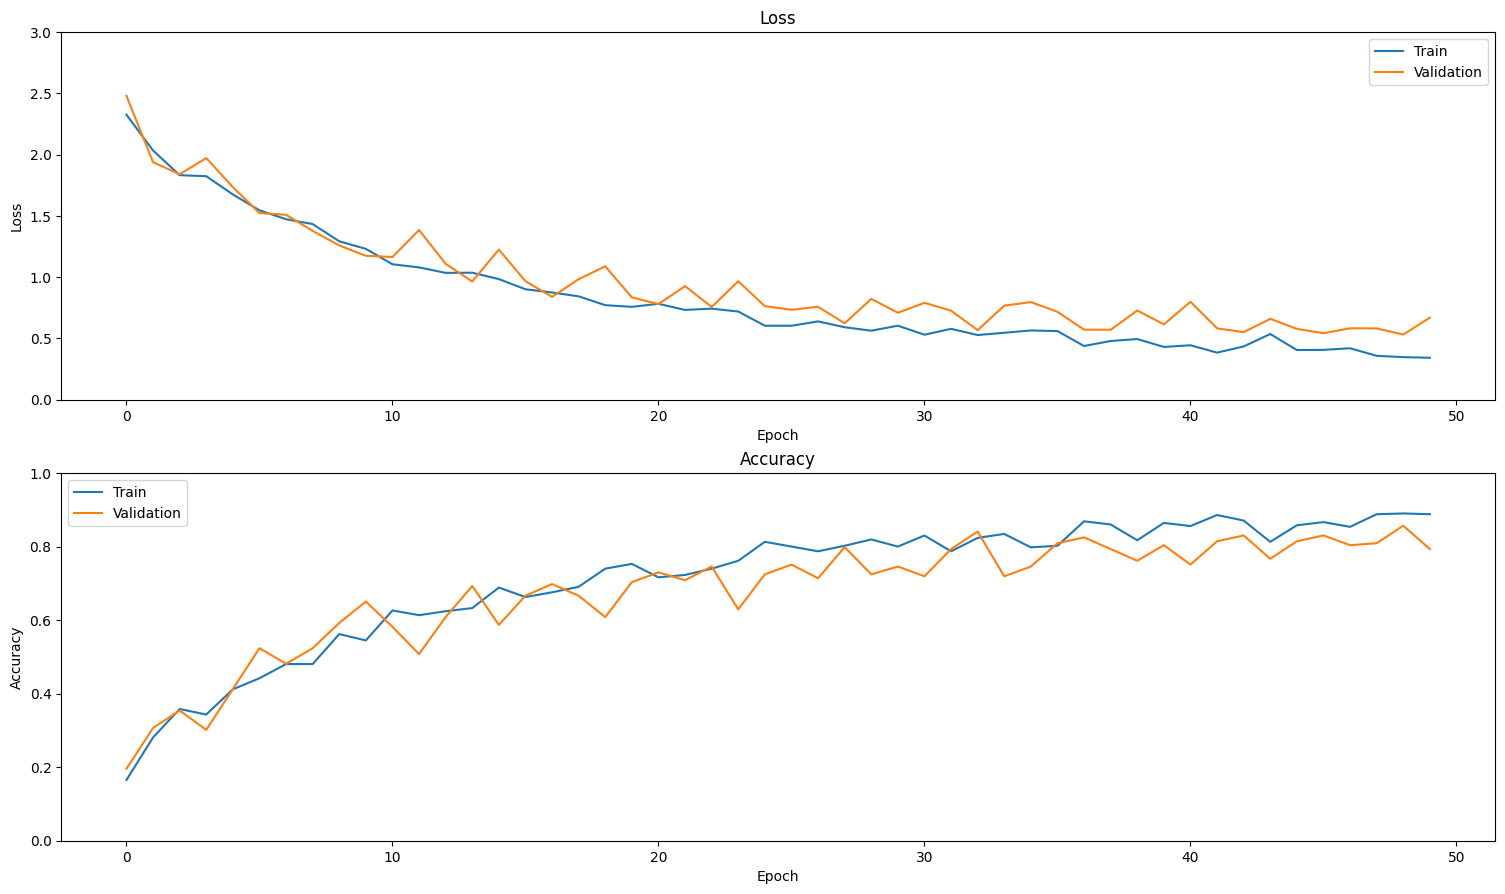

In [27]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data. 

In [28]:
model.evaluate(test_ds, return_dict=True)

22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7423 - loss: 0.7614


2025-05-03 16:19:24.409086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6642507435798440737
2025-05-03 16:19:24.409889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6487658019690581232


{'accuracy': 0.7613636255264282, 'loss': 0.7252630591392517}

      5/Unknown 4s 900ms/step - accuracy: 0.8775 - loss: 0.4640

      6/Unknown 5s 859ms/step - accuracy: 0.8528 - loss: 0.5109

      7/Unknown 6s 857ms/step - accuracy: 0.8253 - loss: 0.6026

      8/Unknown 7s 875ms/step - accuracy: 0.8062 - loss: 0.6715

      9/Unknown 8s 889ms/step - accuracy: 0.7891 - loss: 0.7244

     10/Unknown 9s 899ms/step - accuracy: 0.7752 - loss: 0.7633

     11/Unknown 10s 911ms/step - accuracy: 0.7636 - loss: 0.7949

     12/Unknown 11s 889ms/step - accuracy: 0.7564 - loss: 0.8147

     13/Unknown 11s 838ms/step - accuracy: 0.7513 - loss: 0.8292

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 838ms/step - accuracy: 0.7469 - loss: 0.8416


{'accuracy': 0.6899999976158142, 'loss': 1.0032306909561157}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [29]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [30]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [31]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

59/59 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step


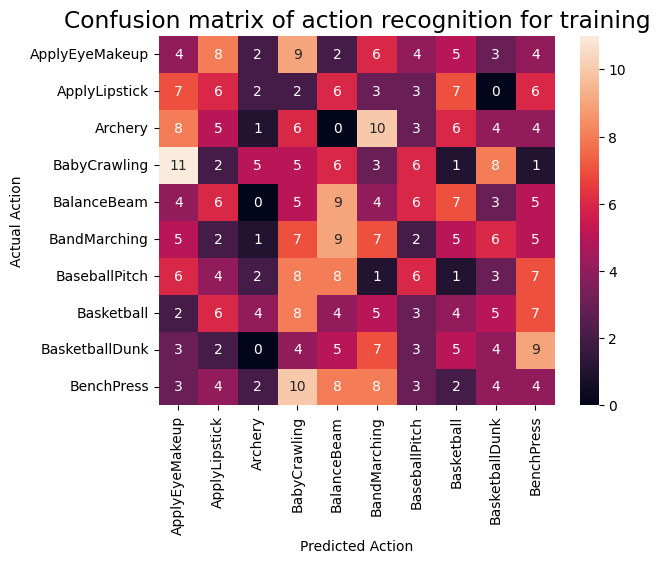

      5/Unknown 6s 693ms/step

      6/Unknown 7s 746ms/step

      7/Unknown 8s 770ms/step

      8/Unknown 9s 793ms/step

      9/Unknown 9s 800ms/step

     10/Unknown 11s 842ms/step

     11/Unknown 11s 825ms/step

     12/Unknown 12s 835ms/step

     13/Unknown 13s 833ms/step

     14/Unknown 14s 822ms/step

     15/Unknown 15s 820ms/step

     16/Unknown 15s 828ms/step

     17/Unknown 16s 829ms/step

     18/Unknown 17s 835ms/step

     19/Unknown 18s 834ms/step

     20/Unknown 19s 831ms/step

     21/Unknown 20s 828ms/step

     22/Unknown 20s 826ms/step

     23/Unknown 21s 832ms/step

     24/Unknown 22s 830ms/step

     25/Unknown 23s 832ms/step

     26/Unknown 24s 832ms/step

     27/Unknown 25s 831ms/step

     28/Unknown 26s 833ms/step

     29/Unknown 26s 837ms/step

     30/Unknown 27s 834ms/step

     31/Unknown 28s 835ms/step

     32/Unknown 29s 833ms/step

     33/Unknown 30s 836ms/step

     34/Unknown 31s 840ms/step

     35/Unknown 32s 843ms/step

     36/Unknown 33s 846ms/step

     37/Unknown 34s 847ms/step

     38/Unknown 36s 890ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 890ms/step


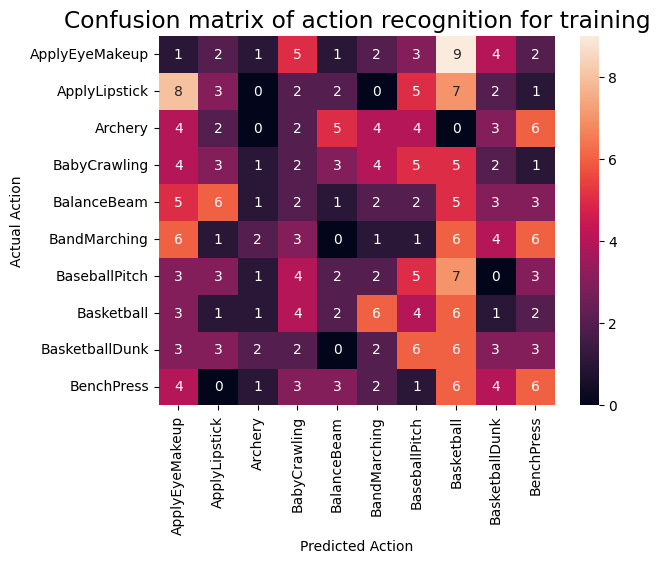

In [32]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


/home/rs/miniconda3/envs/tfenv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


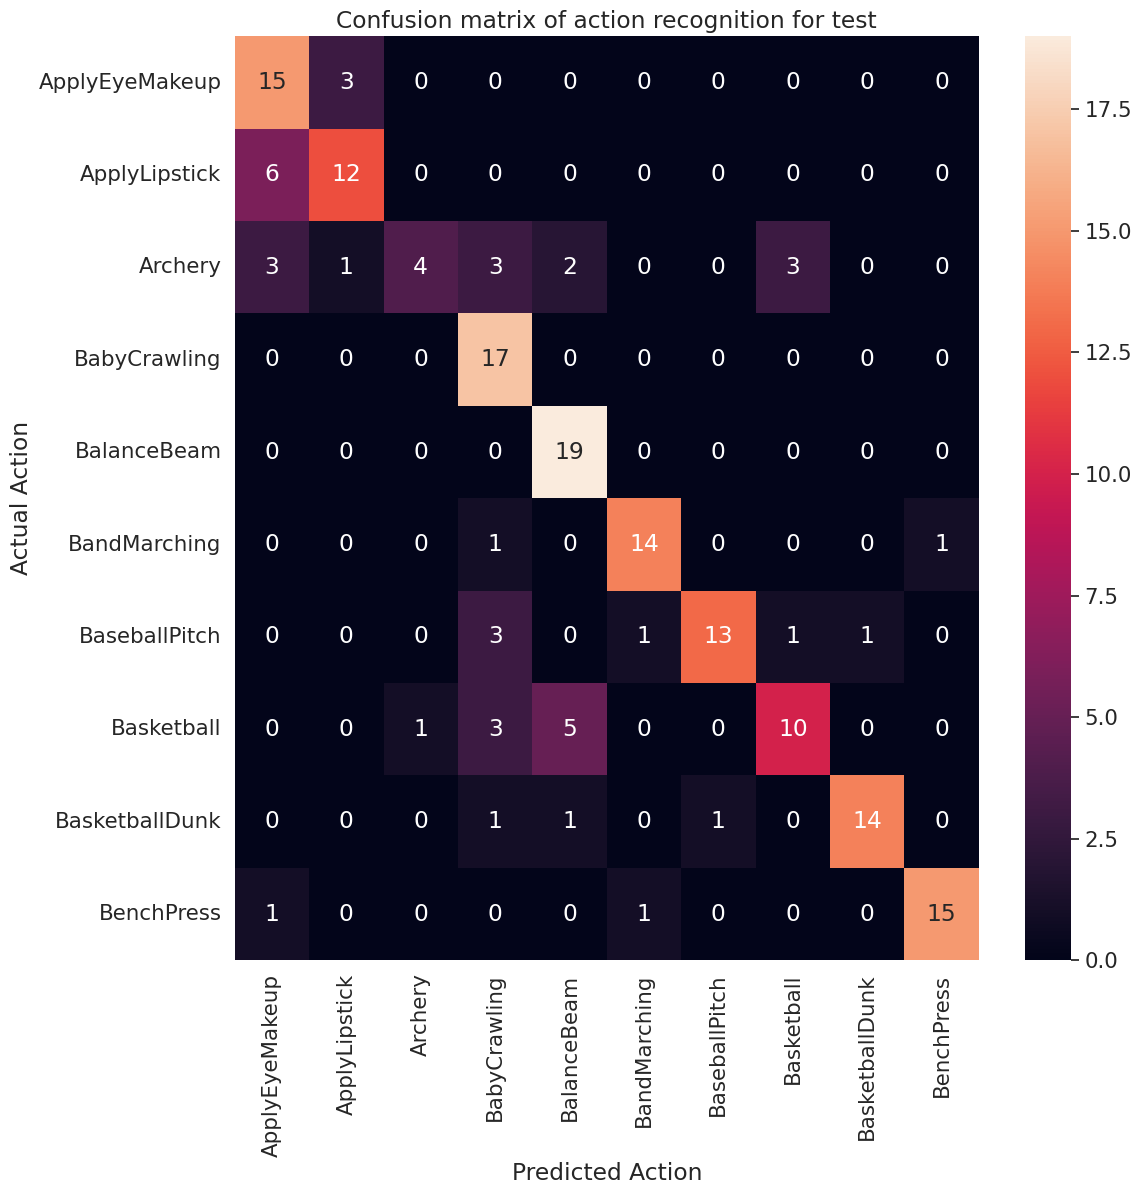

      7/Unknown 6s 865ms/step

      8/Unknown 7s 877ms/step

      9/Unknown 8s 896ms/step

     10/Unknown 9s 898ms/step

     11/Unknown 10s 913ms/step

     12/Unknown 11s 889ms/step

     13/Unknown 11s 841ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 841ms/step


/usr/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


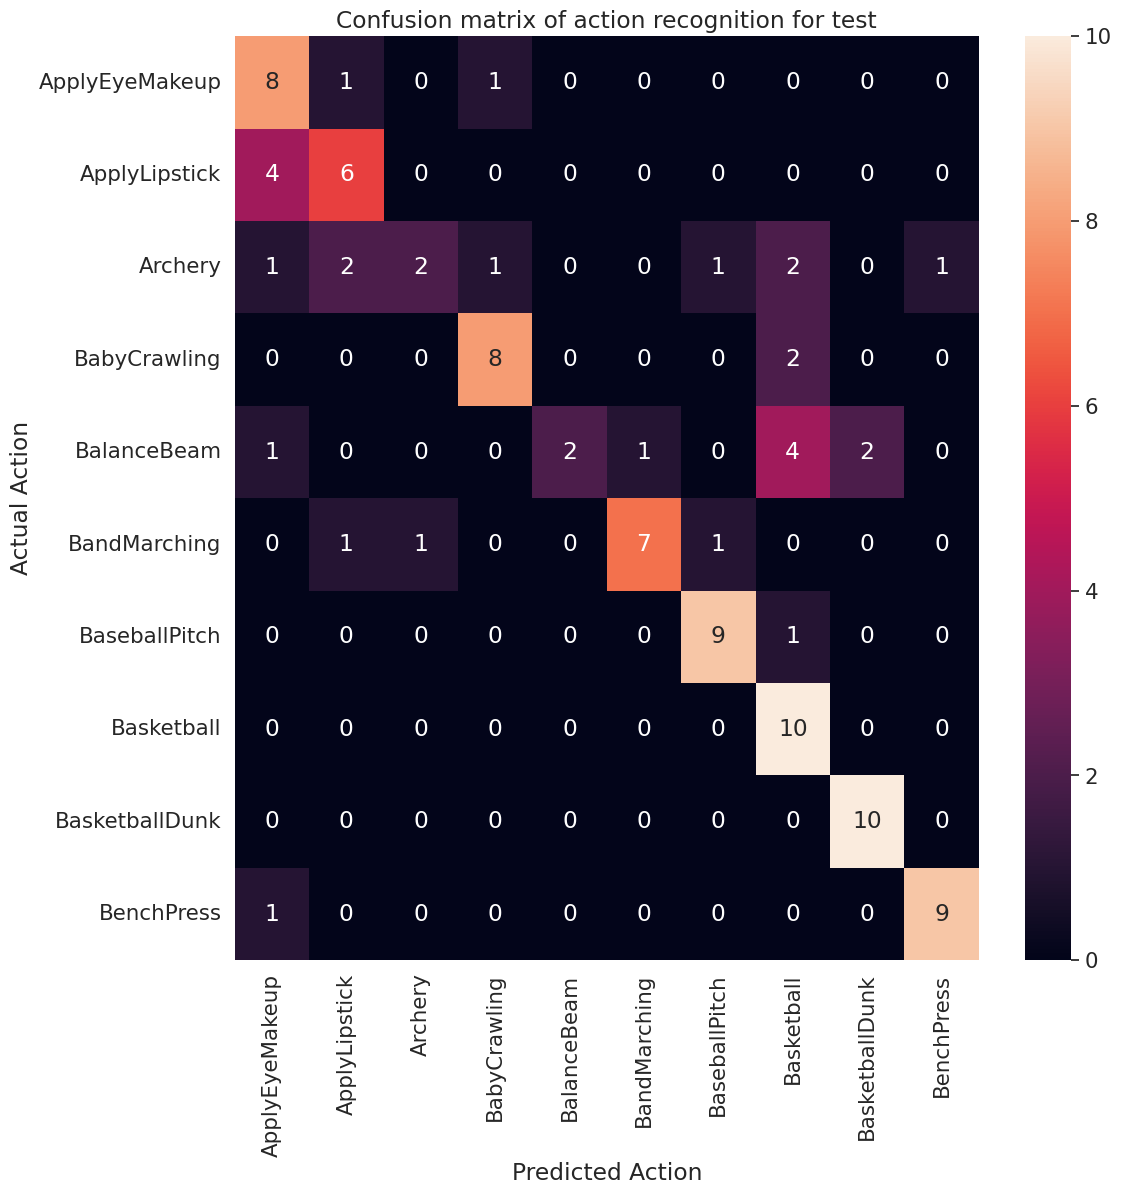

In [33]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [25]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [26]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [27]:
precision

{'ApplyEyeMakeup': 0.5333333333333333,
 'ApplyLipstick': 0.6,
 'Archery': 0.6666666666666666,
 'BabyCrawling': 0.8,
 'BalanceBeam': 1.0,
 'BandMarching': 0.875,
 'BaseballPitch': 0.8181818181818182,
 'Basketball': 0.5263157894736842,
 'BasketballDunk': 0.8333333333333334,
 'BenchPress': 0.9}

In [28]:
recall

{'ApplyEyeMakeup': 0.8,
 'ApplyLipstick': 0.6,
 'Archery': 0.2,
 'BabyCrawling': 0.8,
 'BalanceBeam': 0.2,
 'BandMarching': 0.7,
 'BaseballPitch': 0.9,
 'Basketball': 1.0,
 'BasketballDunk': 1.0,
 'BenchPress': 0.9}

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)